# 准备数据

In [ ]:
!pip list

In [3]:
from tqdm import tqdm
import time
for i in tqdm(range(1, 60)):
    """
    代码
    """
    # 假设这代码部分需要0.05s，循环执行60次
    time.sleep(0.05)

100%|██████████| 59/59 [00:03<00:00, 19.58it/s]


In [18]:
# !pip install factor_analyzer
# !pip install xlwt
# !pip install seaborn
# !pip install collection
!pip install torchsummary

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [8]:
from datasets import load_dataset

dataset = load_dataset('imdb')

Using the latest cached version of the module from /root/.cache/huggingface/modules/datasets_modules/datasets/imdb/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1 (last modified on Sat Sep 24 10:15:53 2022) since it couldn't be found locally at imdb., or remotely on the Hugging Face Hub.
Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
print(len(dataset['train']), len(dataset['test']), len(dataset['unsupervised']))
dataset['train'][0]

25000 25000 50000


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [3]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
import seaborn as sns
import math
from gensim.models import word2vec
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

In [10]:
file_path = 'autodl-tmp/'

In [4]:
train_text, train_label = [], []
for onedata in dataset['train']:
    text, label = onedata['text'], onedata['label']
    train_text.append(text)
    train_label.append(label)
print(f'训练数据的数量: {len(train_text)}条')

train_tokens = d2l.tokenize(train_text, token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
print('词表大小: ', len(vocab))
print('前50个token: ', vocab.idx_to_token[:50])

训练数据的数量: 25000条
词表大小:  49347
前50个token:  ['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'I', 'that', 'this', 'it', '/><br', 'was', 'as', 'with', 'for', 'but', 'The', 'on', 'movie', 'are', 'his', 'film', 'have', 'not', 'be', 'you', 'he', 'by', 'at', 'one', 'an', 'from', 'who', 'like', 'all', 'they', 'has', 'so', 'just', 'about', 'or', 'her', 'out', 'some', 'very', 'more', 'This']


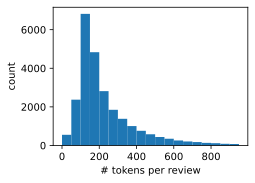

In [5]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

In [12]:
num_steps = 500  # 序列长度
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [13]:
train_iter = d2l.load_array((train_features,
    torch.tensor(train_label)), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('小批量数目：', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
小批量数目： 391


# 训练词向量

In [11]:
ord('a')
preprocess(dataset['train'][1]['text'])

'"I Am Curious: Yellow" is a risible and pretentious steaming pile . It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level . As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true . I\'ve seen R-rated films with male nudity . Granted , they only offer some fleeting views , but where are the R-rated films with gaping vulvas and flapping labia ? Nowhere , because they don\'t exist . The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight . And those pretentious indie movies like The Brown Bunny , in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson , but not a trace of pink visible on Chloe Sevigny . Before crying or implying "double-standard" in matters of nudity , the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nud

In [10]:
for v in dataset['train'][:3]:
    print(v)

text
label


In [4]:
# 对于每一段评论文本，去除标点符号和换行符，单词间空格相连
# 需注意，当前处理方法没有把单词中的标点符号去掉
def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' ' and ord(prev_char) >= 97


def preprocess(sentence):
    sentence = sentence.strip('\n').replace('<br /><br />', ' ').replace('(', '').replace(')', '')
    out = [' ' + char if i > 0 and no_space(char, sentence[i - 1]) else char
        for i, char in enumerate(sentence)]
    return ''.join(out)


processed = []
for onedata in dataset['train']:
    processed.append(preprocess(onedata['text']))

print(processed[0])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country , therefore being a fan of films considered "controversial" I really had to see this for myself . The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life . In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States . In between asking politicians and ordinary denizens of Stockholm about their opinions on politics , she has sex with her drama teacher , classmates , and married men . What kills me about I AM CURIOUS-YELLOW is that 40 years ago , this was considered pornographic . Really , the sex and nudity scenes are few and far between , even then it'

In [11]:
processed[10]

'It was great to see some of my favorite stars of 30 years ago including John Ritter , Ben Gazarra and Audrey Hepburn . They looked quite wonderful . But that was it . They were not given any characters or good lines to work with . I neither understood or cared what the characters were doing . Some of the smaller female roles were fine , Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts . They showed some talent and it is sad they didn\'t go on to star in more and better films . Sadly , I didn\'t think Dorothy Stratten got a chance to act in this her only important film role . The film appears to have some fans , and I was very open-minded when I started watching it . I am a big Peter Bogdanovich fan and I enjoyed his last movie , "Cat\'s Meow" and all his early ones from "Targets" to "Nickleodeon". So , it really surprised me that I was barely able to keep awake watching this one . It is ironic that this movie is about a detective agency wh

In [ ]:
punc = set(',.?!')
words = [[word for word in sen.split(' ') if word not in punc] for sen in processed]
words[0]

In [9]:
len(words), len(words[0])

(25000, 285)

In [10]:
vocab = d2l.Vocab(words, min_freq=5, reserved_tokens=['<pad>'])
print('词表大小: ', len(vocab))
print('前50个token: ', vocab.idx_to_token[:50])

词表大小:  37651
前50个token:  ['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'I', 'that', 'it', 'this', 'was', 'as', 'with', 'movie', 'for', 'The', 'film', 'but', 'on', 'are', 'his', 'not', 'have', 'you', 'be', 'one', 'he', 'at', 'by', 'all', 'an', 'who', 'from', 'like', 'they', 'her', 'so', 'about', 'or', 'has', 'just', 'out', 'This', 'some', 'good', 'more', 'very']


In [14]:
# 训练词向量
file_path = 'autodl-tmp/'
model = word2vec.Word2Vec(sentences=words, vector_size=512, sg=1, min_count=5)
# model.save(file_path + "imdb_word_vec_sg.bin")

In [15]:
model.save(file_path + "imdb_word_vec_sg.bin")

# 因子分析

In [4]:
model = word2vec.Word2Vec.load(file_path + 'imdb_word_vec_sg.bin')
embedding = np.array([model.wv[word] for word in model.wv.index_to_key])
embedding.shape

(37649, 512)

In [ ]:
model.wv['fascinating']

In [5]:
# Bartlett's球状检验
print('Bartlett\'s球状检验: 检验总体变量的相关矩阵是否是单位阵')
chi_square_value, p_value = calculate_bartlett_sphericity(embedding)
print(chi_square_value, p_value)

# 导入kmo检验
print('kmo检验:')
print('检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好')
kmo_all, kmo_model = calculate_kmo(embedding)
print('KMO值为: ', kmo_model)

Bartlett's球状检验: 检验总体变量的相关矩阵是否是单位阵


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/factor_analyzer.py:108: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


inf 0.0
kmo检验:
检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO值为:  0.7556861312416779


In [6]:
# fa = FactorAnalyzer(25, rotation='varimax')
print('因子分析')
fa = FactorAnalyzer(25, rotation=None)
fa.fit(embedding)

# 特征值、特征向量
ev, v = fa.get_eigenvalues()

因子分析


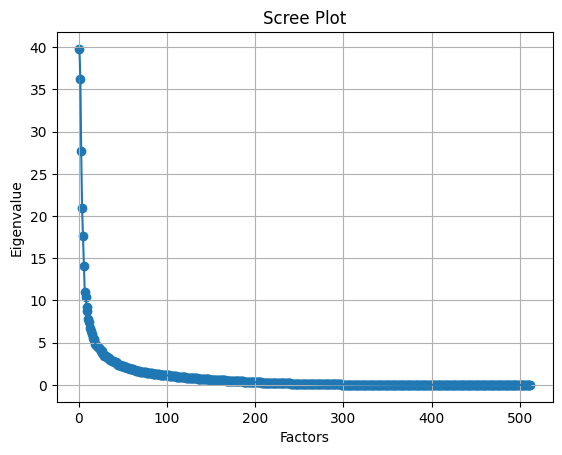

In [7]:
# 可视化
# plot横轴是指标个数，纵轴是ev值
plt.scatter(range(1, embedding.shape[1]+1), ev)
plt.plot(range(1, embedding.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# plt.savefig('ev.png')

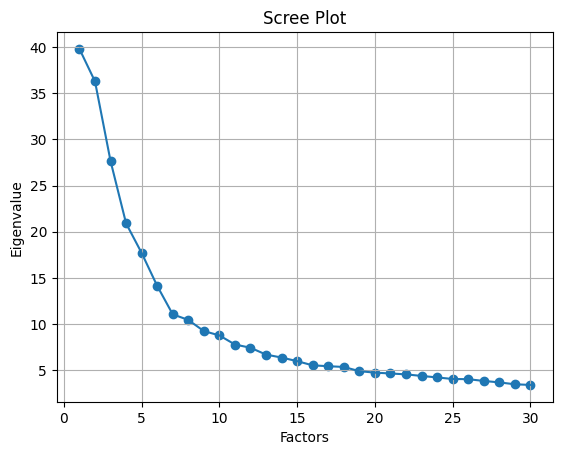

<Figure size 640x480 with 0 Axes>

In [8]:
# 前三十
plt.scatter(range(1, 31), ev[:30])
plt.plot(range(1, 31), ev[:30])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
plt.savefig(file_path + 'ev30.png')

In [11]:
# fa = FactorAnalyzer(8, rotation="promax")
# fa.fit(embedding)
# print(fa.loadings_.shape)

# 512*8(变量个数*因子个数)
index = fa.loadings_.argmax(axis=1)
res = np.array([[i, idx] for i, idx in enumerate(index)])

data_1 = pd.DataFrame(fa.loadings_, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])
data_2 = pd.DataFrame(res, columns=['Dimension', 'Factor'])
with pd.ExcelWriter(file_path + "FA.xls") as writer1:
    data_1.to_excel(writer1, sheet_name="Sheet1")
    data_2.to_excel(writer1, sheet_name="Sheet2")
    writer1.save()

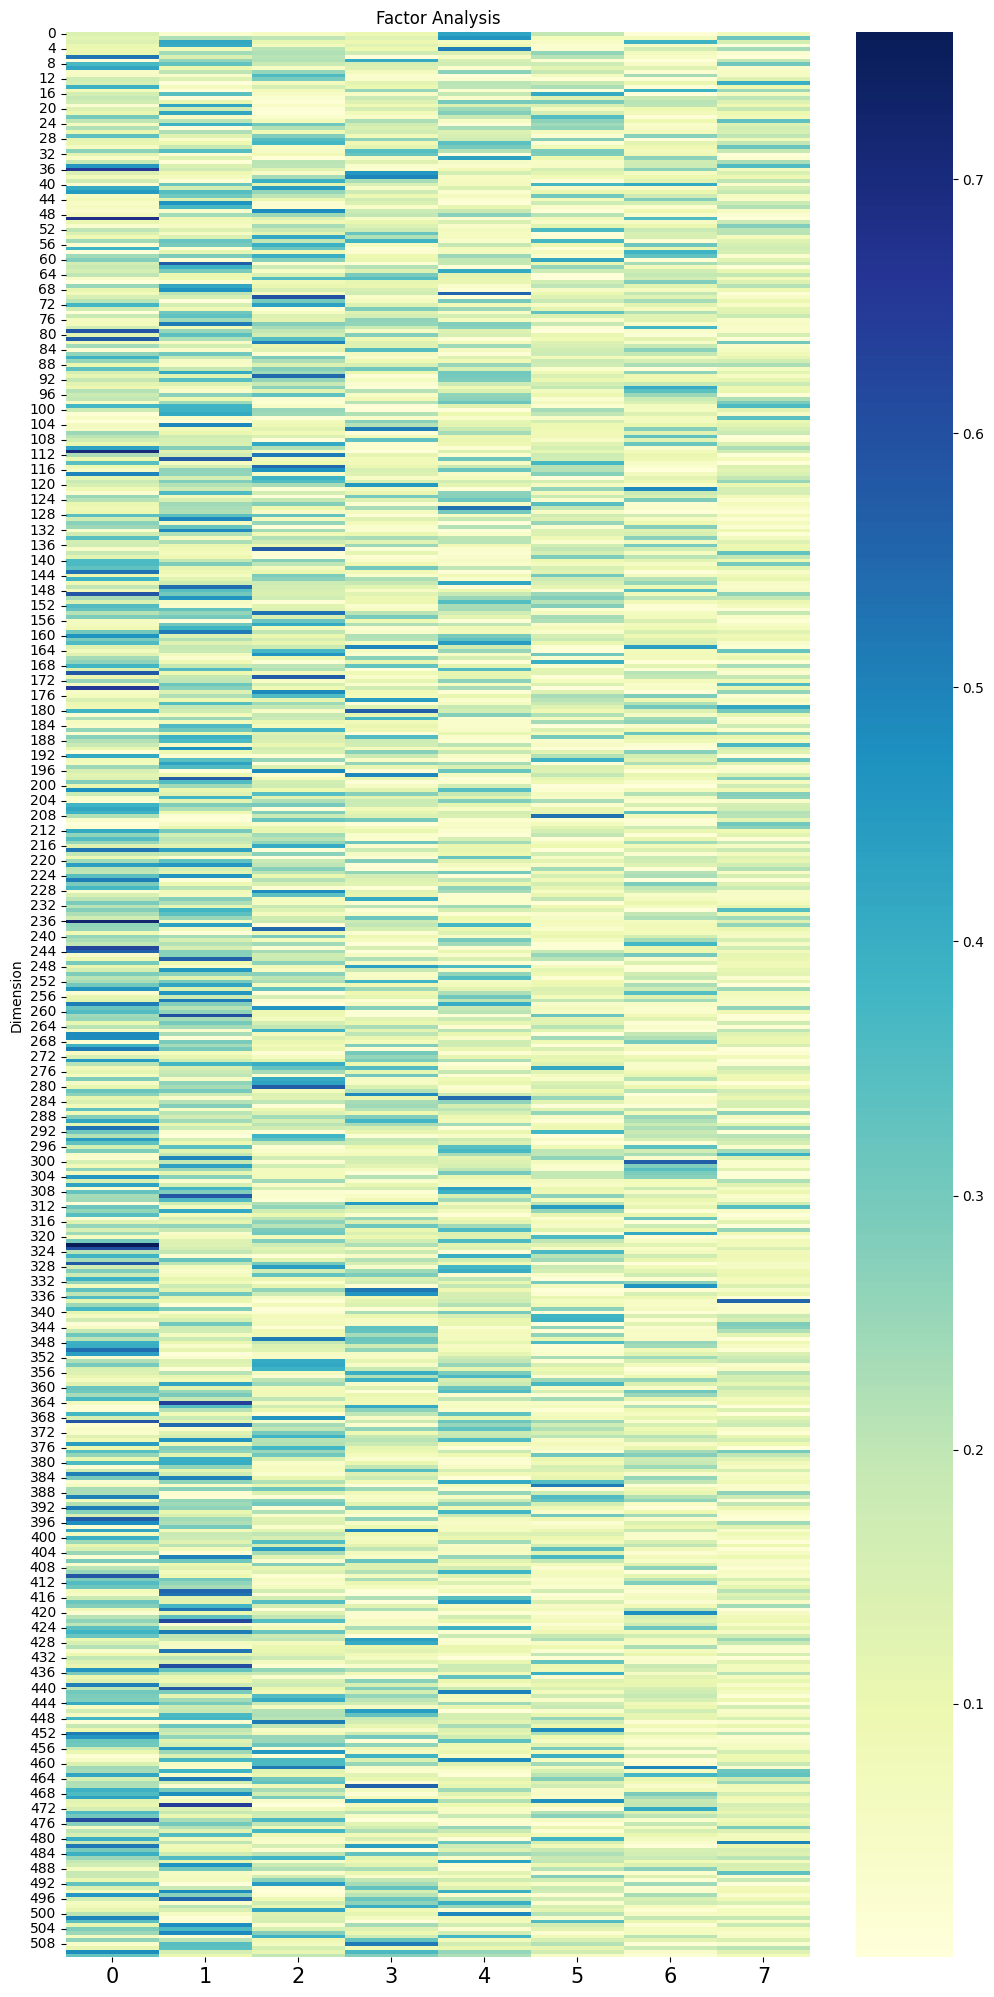

In [18]:
# 因子分析结果可视化
import seaborn as sns
df_cm = pd.DataFrame(np.abs(fa.loadings_))
fig,ax = plt.subplots(figsize=(12,25))
sns.heatmap(df_cm, annot = None, cmap='YlGnBu',ax=ax)  # cbar_kws


# dict_={'orientation':'vertical',"label":"color  \
# scale","drawedges":True,"ticklocation":"top","extend":"min", \
# "filled":True,"alpha":0.8,"cmap":"cmap","ticks":tick_}
# cbar_kws = dict_

# 设置y轴字体的大小
ax.tick_params(axis='x',labelsize=15)
ax.set_title("Factor Analysis",fontsize=12)
ax.set_ylabel("Dimension")
plt.savefig(file_path + 'dimension.png')

# 模型架构

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import time
import math
from gensim.models import word2vec

In [2]:
class FlexiHeadAttention(nn.Module):
    """修改多头注意力，针对嵌入512维，8个head的模型"""

    def __init__(self, num_hiddens, dim_dict, dropout, bias=False, **kwargs):
        super(FlexiHeadAttention, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dim_dict = dim_dict
        self.dim_0 = [dim for dim, idx in self.dim_dict.items() if idx == 0]
        self.dim_1 = [dim for dim, idx in self.dim_dict.items() if idx == 1]
        self.dim_2 = [dim for dim, idx in self.dim_dict.items() if idx == 2]
        self.dim_3 = [dim for dim, idx in self.dim_dict.items() if idx == 3]
        self.dim_4 = [dim for dim, idx in self.dim_dict.items() if idx == 4]
        self.dim_5 = [dim for dim, idx in self.dim_dict.items() if idx == 5]
        self.dim_6 = [dim for dim, idx in self.dim_dict.items() if idx == 6]
        self.dim_7 = [dim for dim, idx in self.dim_dict.items() if idx == 7]
        # self.list_concat = torch.cat((self.dim_0, self.dim_1, self.dim_2, self.dim_3, self.dim_4, self.dim_5,
        # self.dim_6, self.dim_7))
        self.len_0, self.len_1, self.len_2, self.len_3, self.len_4, self.len_5, self.len_6, self.len_7 = len(
            self.dim_0), len(self.dim_1), len(self.dim_2), len(self.dim_3), len(self.dim_4), len(self.dim_5),\
            len(self.dim_6), len(self.dim_7)

        self.Wq0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wq1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wq2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wq3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wq4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wq5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wq6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wq7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wk0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wk1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wk2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wk3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wk4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wk5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wk6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wk7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wv0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wv1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wv2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wv3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wv4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wv5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wv6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wv7 = nn.Linear(self.len_7, self.len_7, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        def assemble(output_concat, list_concat):
            reslist = []
            for i in range(512):
                reslist.append(list_concat.index(i))
            return torch.index_select(output_concat, -1, torch.tensor(reslist, device=output_concat.device))

        # queries, keys, values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # qi, ki, vi的形状：(batch_size, 查询或者“键－值”对的个数， self.len_i)
        q0, k0, v0 = torch.index_select(queries, -1, torch.tensor(self.dim_0, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_0, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_0, device=values.device))
        q1, k1, v1 = torch.index_select(queries, -1, torch.tensor(self.dim_1, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_1, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_1, device=values.device))
        q2, k2, v2 = torch.index_select(queries, -1, torch.tensor(self.dim_2, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_2, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_2, device=values.device))
        q3, k3, v3 = torch.index_select(queries, -1, torch.tensor(self.dim_3, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_3, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_3, device=values.device))
        q4, k4, v4 = torch.index_select(queries, -1, torch.tensor(self.dim_4, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_4, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_4, device=values.device))
        q5, k5, v5 = torch.index_select(queries, -1, torch.tensor(self.dim_5, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_5, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_5, device=values.device))
        q6, k6, v6 = torch.index_select(queries, -1, torch.tensor(self.dim_6, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_6, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_6, device=values.device))
        q7, k7, v7 = torch.index_select(queries, -1, torch.tensor(self.dim_7, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_7, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_7, device=values.device))

        head0 = self.attention(self.Wq0(q0), self.Wk0(k0), self.Wv0(v0), valid_lens)
        head1 = self.attention(self.Wq1(q1), self.Wk1(k1), self.Wv1(v1), valid_lens)
        head2 = self.attention(self.Wq2(q2), self.Wk2(k2), self.Wv2(v2), valid_lens)
        head3 = self.attention(self.Wq3(q3), self.Wk3(k3), self.Wv3(v3), valid_lens)
        head4 = self.attention(self.Wq4(q4), self.Wk4(k4), self.Wv4(v4), valid_lens)
        head5 = self.attention(self.Wq5(q5), self.Wk5(k5), self.Wv5(v5), valid_lens)
        head6 = self.attention(self.Wq6(q6), self.Wk6(k6), self.Wv6(v6), valid_lens)
        head7 = self.attention(self.Wq7(q7), self.Wk7(k7), self.Wv7(v7), valid_lens)

        output_concat = torch.cat((head0, head1, head2, head3, head4, head5, head6, head7), dim=-1)
        list_concat = self.dim_0 + self.dim_1 + self.dim_2 + self.dim_3 + self.dim_4 + self.dim_5 + self.dim_6 + self.dim_7
        return self.W_o(assemble(output_concat, list_concat))

In [3]:
# 编码器块
class EncoderBlock(nn.Module):
    """transformer编码器块"""

    def __init__(self, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = FlexiHeadAttention(num_hiddens, dim_dict, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [8]:
# 编码器
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""

    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout, num_output,
                 use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.outhidden = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU())
        self.Dense = nn.Linear(num_hiddens, num_output)
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(num_hiddens, norm_shape, ffn_num_input,
                                              ffn_num_hiddens, dim_dict, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        # 取句首'cls'token的向量用于情感分类
        return self.Dense(self.outhidden(X[:, 0, :]))

In [13]:
# 卷积的编码器
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""

    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout, num_output,
                 kernel_size, stride, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.conv = nn.Conv1d(num_hiddens, 1, kernel_size, stride)
        self.relu = nn.ReLU()
        self.Dense = nn.Linear(100, num_output)
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(num_hiddens, norm_shape, ffn_num_input,
                                              ffn_num_hiddens, dim_dict, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        # 交换X的num_steps和num_hiddens两个维度
        X = X.permute(0, 2, 1)
        out = torch.squeeze(self.relu(self.conv(X)), dim=1)
        return self.Dense(out)

In [ ]:
# self.outhidden = nn.Sequential(nn.Linear(num_hiddens, num_hiddens),
#                                     nn.Tanh())
# self.Dense(self.outhidden(X[: 0, :]))

In [ ]:
Net = TransformerEncoder(200, 512, [512], 512, 512, dim_dict, 2, 0.1, 2)
Net.eval()
valid_lens = torch.tensor([3, 2])
Net(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

In [ ]:
# device = d2l.try_gpu()
net.to(device)
print('net device:', next(net.parameters()).device)
# cuda = next(net.parameters()).device
for X, valid_len, _ in train_iter:
    X, valid_len = [v.to(device) for v in (X, valid_len)]
    # valid_len = valid_len.to(cuda)
    print(X.device)
    y = torch.ones(64, dtype=torch.long, device=cuda)
    print(net(X, valid_len))
    print(l(net(X, valid_len), y))
    break

In [95]:
a = torch.rand((2, 3))
b = torch.ones((2), dtype=torch.long)
l = nn.CrossEntropyLoss()
l(a, b)

tensor(1.5948)

In [70]:
a[:,0].device

device(type='cpu')

In [11]:
# 训练准备
excelfile = pd.read_excel(file_path + 'FA.xls', sheet_name='Sheet2', header=0, index_col=0)
dim_dict = dict()
for i in range(512):
    dim_dict[excelfile['Dimension'].values[i]] = excelfile['Factor'].values[i]

In [29]:
Net = TransformerEncoder(200, 512, [512], 512, 512, dim_dict, 2, 0.1, 2)
Net.eval()
valid_lens = torch.tensor([3, 2])
Net(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 2])

In [ ]:
for name, parameters in Net.named_parameters():
    print(name, ';', parameters.size())

# 加载数据

In [5]:
# 数据
dataset = load_dataset('imdb')
print('训练集长度:', len(dataset['train']), '测试集长度:', len(dataset['test']), '无标签集长度:', len(dataset['unsupervised']))

# 对于每一段评论文本，去除标点符号和换行符，单词间空格相连
# 需注意，当前处理方法没有把单词中的标点符号去掉
def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' ' and ord(prev_char) >= 97


def preprocess(sentence):
    sentence = sentence.strip('\n').replace('<br /><br />', ' ').replace('(', '').replace(')', '')
    out = [' ' + char if i > 0 and no_space(char, sentence[i - 1]) else char
        for i, char in enumerate(sentence)]
    return ''.join(out)


def load_datawords(dataset):
    processed = []
    for onedata in dataset:
        processed.append(preprocess(onedata['text']))

    punc = set(',.?!')
    words = [[word for word in sen.split(' ') if word not in punc] for sen in processed]
    return [['<cls>'] + line for line in words]


train_words = load_datawords(dataset['train'])
vocab = d2l.Vocab(train_words, min_freq=5, reserved_tokens=['<pad>', '<cls>'])
print('词表大小: ', len(vocab))
print('前50个token: ', vocab.idx_to_token[:50])

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

训练集长度: 25000 测试集长度: 25000 无标签集长度: 50000
词表大小:  37652
前50个token:  ['<unk>', '<pad>', '<cls>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'I', 'that', 'it', 'this', 'was', 'as', 'with', 'movie', 'for', 'The', 'film', 'but', 'on', 'are', 'his', 'not', 'have', 'you', 'be', 'one', 'he', 'at', 'by', 'all', 'an', 'who', 'from', 'like', 'they', 'her', 'so', 'about', 'or', 'has', 'just', 'out', 'This', 'some', 'good', 'more']


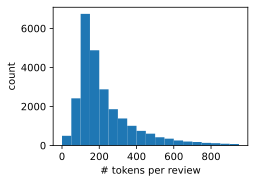

In [5]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_words], bins=range(0, 1000, 50));

In [6]:
# 生成训练数据集、测试数据集
# print(len(dataset['train'][:]['label']))
def load_imdb_data(datawords, vocab, dataset, batch_size, num_steps):
    data_tokens = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in datawords])
    valid_lens = (data_tokens != vocab['<pad>']).type(torch.int32).sum(1)
    labels = torch.tensor(dataset[:]['label'])
    return d2l.load_array((data_tokens, valid_lens, labels), batch_size)


batch_size, num_steps = 64, 500
train_iter = load_imdb_data(train_words, vocab, dataset['train'], batch_size, num_steps)
for X, valid_len, y in train_iter:
    print('X:', X.shape, ', y:', y.shape, ', valid_len:', valid_len.shape)
    break
print('小批量数目：', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64]) , valid_len: torch.Size([64])
小批量数目： 391


In [75]:
for X, valid_len, y in train_iter:
    print(y)
    break
print('小批量数目：', len(train_iter))

tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1])
小批量数目： 391


In [74]:
# sum(i for i in dataset['train'][:]['label'] if i == 0)
dataset['train'][:]['label'][20000:20020]
# from collections import Counter
# Counter(dataset['train'][:]['label'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [7]:
# def load_datawords(dataset):
#     processed = []
#     for onedata in dataset:
#         processed.append(preprocess(onedata['text']))

#     punc = set(',.?!')
#     words = [[word for word in sen.split(' ') if word not in punc] for sen in processed]
#     return [['cls'] + line for line in words]
test_words = load_datawords(dataset['test'])

test_iter = load_imdb_data(test_words, vocab, dataset['test'], 64, 500)

In [10]:
dataset['test'][0]['text']

'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as they have

In [8]:
for X, valid_len, y in test_iter:
    print('X:', X, ', y:', y, ', valid_len:', valid_len)
    break

X: tensor([[    2,  4248,    11,  ...,     1,     1,     1],
        [    2,   403,     3,  ...,     1,     1,     1],
        [    2,   271,    10,  ...,     1,     1,     1],
        ...,
        [    2,  6432, 11889,  ...,     1,     1,     1],
        [    2,   132,   418,  ...,     1,     1,     1],
        [    2,   303,    53,  ...,  1737,   313,    16]]) , y: tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]) , valid_len: tensor([288, 155, 173, 331, 500, 101, 169, 267, 155, 130, 163, 221,  90, 201,
        228, 142, 201, 293, 263, 150, 436, 267,  64, 410, 171, 141, 174, 500,
        314, 260,  68, 500, 221, 187, 161,  63, 225, 268, 132,  73,  99, 187,
        192, 128, 256, 143, 188, 217, 128, 500, 107, 130, 296, 104, 159, 112,
        234,  80, 203, 107,  65, 151, 195, 500])


In [13]:
num_steps = 500  # 序列长度（句首加了一个'cls'字符）

train_tokens = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in words])
print('train_tokens: ', train_tokens.shape)

valid_lens = (train_tokens != vocab['<pad>']).type(torch.int32).sum(1)
print('valid_lens: ', valid_lens.shape)

train_label = dataset['train'][:]['label']

train_iter = d2l.load_array((train_tokens, valid_lens,
    torch.tensor(train_label)), 64)

for X, valid_len, y in train_iter:
    print('X:', X.shape, ', y:', y.shape, ', valid_len:', valid_len.shape)
    break
print('小批量数目：', len(train_iter))

train_tokens:  torch.Size([25000, 500])
valid_lens:  torch.Size([25000])
X: torch.Size([64, 500]) , y: torch.Size([64]) , valid_len: torch.Size([64])
小批量数目： 391


# 模型训练

In [9]:
num_hiddens, num_layers, dropout, num_output = 512, 1, 0.1, 2
ffn_num_input, ffn_num_hiddens, num_heads, norm_shape = 512, 2048, 8, [512]
lr, num_epochs, device = 5e-5, 60, d2l.try_gpu()

In [8]:
# 一维卷积的模型参数设置
num_hiddens, num_layers, dropout, num_output = 512, 1, 0.1, 2
ffn_num_input, ffn_num_hiddens, num_heads, norm_shape = 512, 2048, 8, [512]
kernel_size, stride = 5, 5
lr, num_epochs, device = 5e-5, 60, d2l.try_gpu()

In [10]:
file_path = 'autodl-tmp/'
excelfile = pd.read_excel(file_path + 'FA.xls', sheet_name='Sheet2', header=0, index_col=0)
dim_dict = dict()
for i in range(512):
    dim_dict[excelfile['Dimension'].values[i]] = excelfile['Factor'].values[i]

In [11]:
# 模型和模型参数数量
net = TransformerEncoder(
    len(vocab), num_hiddens, norm_shape,
    ffn_num_input, ffn_num_hiddens, dim_dict,
    num_layers,dropout, num_output)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

22,017,010 total parameters.
22,017,010 training parameters.


In [12]:
# 初始化embedding层模型权重
def get_embedding_weights(vocab, word2vecmodel, num_hiddens):
    wordlist = word2vecmodel.wv.index_to_key
    n = len(vocab)
    data = np.random.randn(n, num_hiddens)
    for i in range(n):
        word = vocab.idx_to_token[i]
        data[i] = np.array(word2vecmodel.wv[word]) if word in wordlist else data[i]
    return torch.tensor(data, dtype=torch.float32)


def init_embedding_weights(net, weights):
    for m in net.modules():
        if isinstance(m, nn.Embedding):
            m.weight.data = weights


word2vecmodel = word2vec.Word2Vec.load(file_path + 'imdb_word_vec_sg.bin')
weights = get_embedding_weights(vocab, word2vecmodel, num_hiddens)
init_embedding_weights(net, weights)

In [17]:
net.embedding.weight.data

tensor([[-6.3132e-02,  5.5219e-01, -1.1138e+00,  ...,  1.3116e+00,
         -1.3355e+00,  8.6522e-01],
        [ 9.9875e-02, -1.4728e+00,  3.3636e-01,  ..., -1.5823e+00,
          3.5076e-01, -7.6323e-01],
        [-3.1780e-01,  5.5890e-01, -1.1770e+00,  ..., -1.5757e+00,
          1.0768e-01, -3.6887e-01],
        ...,
        [ 1.9786e-02, -5.3197e-02, -1.1976e-02,  ..., -7.5719e-02,
         -1.0359e-03, -3.6082e-02],
        [ 1.6387e-02, -7.1717e-02, -1.3045e-02,  ..., -9.8970e-02,
          1.1142e-02, -3.3435e-02],
        [ 1.8146e-02, -6.5491e-02, -6.6009e-03,  ..., -9.0076e-02,
          2.5716e-02, -6.0791e-02]])

In [17]:
net.blks.block0.attention.Wq0.weight.data

tensor([[ 0.0966,  0.0927, -0.0705,  ...,  0.0137,  0.0379, -0.0268],
        [-0.0350, -0.0478,  0.0350,  ...,  0.0296,  0.0083,  0.0726],
        [-0.0110,  0.0190, -0.0818,  ...,  0.0088, -0.0249, -0.0805],
        ...,
        [-0.0718, -0.0465,  0.0001,  ...,  0.0532,  0.0030, -0.0054],
        [-0.0243,  0.0474,  0.0173,  ..., -0.0814,  0.0798, -0.0093],
        [ 0.0029,  0.0011,  0.0477,  ..., -0.0102, -0.0831, -0.0323]])

In [13]:
# 初始化线性层权重
def xavier_init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


net.apply(xavier_init_weights)

TransformerEncoder(
  (embedding): Embedding(37652, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): FlexiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_o): Linear(in_features=512, out_features=512, bias=False)
        (Wq0): Linear(in_features=105, out_features=105, bias=False)
        (Wq1): Linear(in_features=98, out_features=98, bias=False)
        (Wq2): Linear(in_features=63, out_features=63, bias=False)
        (Wq3): Linear(in_features=66, out_features=66, bias=False)
        (Wq4): Linear(in_features=55, out_features=55, bias=False)
        (Wq5): Linear(in_features=42, out_features=42, bias=False)
        (Wq6): Linear(in_features=44, out_features=44, bias=False)
        (Wq7): Linear(in_features=39, out_features=39, bias=False)
        (Wk0): Linear(in_features=105, out_features=105, 

In [19]:
net.blks.block0.attention.Wq0.weight.data

tensor([[ 0.1561, -0.1295,  0.0207,  ..., -0.0241, -0.1452,  0.1116],
        [ 0.0589, -0.0107, -0.1414,  ..., -0.0022,  0.1003,  0.0747],
        [ 0.0382, -0.1482,  0.1522,  ...,  0.0693, -0.0310, -0.1197],
        ...,
        [-0.0697,  0.1438,  0.0896,  ...,  0.0909, -0.0760,  0.0310],
        [ 0.0726, -0.0451, -0.0385,  ...,  0.0077, -0.1539, -0.1052],
        [ 0.0794,  0.0535,  0.1506,  ...,  0.0334,  0.0894,  0.0897]])

In [22]:
for name, parameters in net.named_parameters():
    print(name, ';', parameters.size())

embedding.weight ; torch.Size([37652, 512])
blks.block0.attention.W_o.weight ; torch.Size([512, 512])
blks.block0.attention.Wq0.weight ; torch.Size([105, 105])
blks.block0.attention.Wq1.weight ; torch.Size([98, 98])
blks.block0.attention.Wq2.weight ; torch.Size([63, 63])
blks.block0.attention.Wq3.weight ; torch.Size([66, 66])
blks.block0.attention.Wq4.weight ; torch.Size([55, 55])
blks.block0.attention.Wq5.weight ; torch.Size([42, 42])
blks.block0.attention.Wq6.weight ; torch.Size([44, 44])
blks.block0.attention.Wq7.weight ; torch.Size([39, 39])
blks.block0.attention.Wk0.weight ; torch.Size([105, 105])
blks.block0.attention.Wk1.weight ; torch.Size([98, 98])
blks.block0.attention.Wk2.weight ; torch.Size([63, 63])
blks.block0.attention.Wk3.weight ; torch.Size([66, 66])
blks.block0.attention.Wk4.weight ; torch.Size([55, 55])
blks.block0.attention.Wk5.weight ; torch.Size([42, 42])
blks.block0.attention.Wk6.weight ; torch.Size([44, 44])
blks.block0.attention.Wk7.weight ; torch.Size([39, 39]

In [34]:
next(iter(net.parameters())).device

device(type='cpu')

In [14]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for data in data_iter:
            if isinstance(data, list) or isinstance(data, tuple):
                X, valid_len, y = [x.to(device) for x in data]
            else:
                X = X.to(device)
            metric.add(d2l.accuracy(net(X, valid_len), y), d2l.size(y))
    return metric[0] / metric[1]
# evaluate_accuracy_gpu(net, test_iter)

In [27]:
num_epochs = 1

In [36]:
# 以‘微调’的模式进行训练
# 22,130,658 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': forward_params},
    {'params': net.embedding.parameters(),
    'lr': lr * 0.01}], lr=lr)
# animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#         legend=['train loss', 'train acc'])
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    # metric = d2l.Accumulator(4)
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        # metric.add(l.sum(), d2l.accuracy(net(X, valid_len), y), labels.shape[0])
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f}'
     f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost}s')

100%|██████████| 391/391 [01:45<00:00,  3.71it/s]


epoch 1, loss 0.842, train_acc 0.517, test_acc 0.500, taking 132 seconds


100%|██████████| 391/391 [01:42<00:00,  3.83it/s]


epoch 2, loss 0.707, train_acc 0.505, test_acc 0.500, taking 128 seconds


100%|██████████| 391/391 [01:41<00:00,  3.86it/s]


epoch 3, loss 0.697, train_acc 0.506, test_acc 0.500, taking 127 seconds


100%|██████████| 391/391 [01:40<00:00,  3.90it/s]


epoch 4, loss 0.693, train_acc 0.505, test_acc 0.500, taking 126 seconds


100%|██████████| 391/391 [01:41<00:00,  3.86it/s]


epoch 5, loss 0.693, train_acc 0.506, test_acc 0.500, taking 127 seconds


100%|██████████| 391/391 [01:40<00:00,  3.87it/s]


epoch 6, loss 0.694, train_acc 0.505, test_acc 0.500, taking 127 seconds


100%|██████████| 391/391 [01:39<00:00,  3.92it/s]


epoch 7, loss 0.693, train_acc 0.504, test_acc 0.500, taking 126 seconds


100%|██████████| 391/391 [01:38<00:00,  3.95it/s]


epoch 8, loss 0.694, train_acc 0.503, test_acc 0.500, taking 125 seconds


100%|██████████| 391/391 [01:40<00:00,  3.90it/s]


epoch 9, loss 0.694, train_acc 0.501, test_acc 0.500, taking 126 seconds


100%|██████████| 391/391 [01:40<00:00,  3.88it/s]


epoch 10, loss 0.694, train_acc 0.506, test_acc 0.500, taking 127 seconds


100%|██████████| 391/391 [01:44<00:00,  3.76it/s]


epoch 11, loss 0.694, train_acc 0.508, test_acc 0.500, taking 131 seconds


100%|██████████| 391/391 [01:42<00:00,  3.80it/s]


epoch 12, loss 0.695, train_acc 0.503, test_acc 0.500, taking 129 seconds


100%|██████████| 391/391 [01:41<00:00,  3.87it/s]


epoch 13, loss 0.694, train_acc 0.509, test_acc 0.500, taking 127 seconds


100%|██████████| 391/391 [01:40<00:00,  3.91it/s]


epoch 14, loss 0.695, train_acc 0.509, test_acc 0.500, taking 126 seconds


100%|██████████| 391/391 [01:40<00:00,  3.88it/s]


epoch 15, loss 0.696, train_acc 0.511, test_acc 0.500, taking 127 seconds


100%|██████████| 391/391 [01:43<00:00,  3.79it/s]


epoch 16, loss 0.695, train_acc 0.504, test_acc 0.500, taking 129 seconds


100%|██████████| 391/391 [01:45<00:00,  3.70it/s]


epoch 17, loss 0.695, train_acc 0.504, test_acc 0.500, taking 133 seconds


100%|██████████| 391/391 [01:46<00:00,  3.66it/s]


epoch 18, loss 0.695, train_acc 0.507, test_acc 0.500, taking 133 seconds


100%|██████████| 391/391 [01:40<00:00,  3.87it/s]


epoch 19, loss 0.695, train_acc 0.505, test_acc 0.500, taking 127 seconds


100%|██████████| 391/391 [01:42<00:00,  3.83it/s]


epoch 20, loss 0.695, train_acc 0.503, test_acc 0.500, taking 128 seconds


100%|██████████| 391/391 [01:41<00:00,  3.83it/s]


epoch 21, loss 0.694, train_acc 0.504, test_acc 0.500, taking 128 seconds


100%|██████████| 391/391 [01:42<00:00,  3.83it/s]


epoch 22, loss 0.695, train_acc 0.503, test_acc 0.500, taking 128 seconds


100%|██████████| 391/391 [01:41<00:00,  3.84it/s]


epoch 23, loss 0.694, train_acc 0.511, test_acc 0.500, taking 128 seconds


100%|██████████| 391/391 [01:45<00:00,  3.71it/s]


epoch 24, loss 0.694, train_acc 0.510, test_acc 0.500, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.69it/s]


epoch 25, loss 0.695, train_acc 0.503, test_acc 0.500, taking 132 seconds


100%|██████████| 391/391 [01:42<00:00,  3.83it/s]


epoch 26, loss 0.695, train_acc 0.504, test_acc 0.500, taking 128 seconds


100%|██████████| 391/391 [01:43<00:00,  3.77it/s]


epoch 27, loss 0.694, train_acc 0.504, test_acc 0.500, taking 131 seconds


100%|██████████| 391/391 [01:42<00:00,  3.83it/s]


epoch 28, loss 0.694, train_acc 0.501, test_acc 0.500, taking 128 seconds


100%|██████████| 391/391 [01:43<00:00,  3.76it/s]


epoch 29, loss 0.694, train_acc 0.505, test_acc 0.500, taking 130 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 30, loss 0.694, train_acc 0.504, test_acc 0.500, taking 132 seconds
Training is finished.


NameError: name 'accuracy' is not defined

In [38]:
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f} '
     f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost}s')

训练损失:0.694, 训练集准确率:0.504, 测试集准确率:0.500 在设备cuda:0上训练30周期 耗时3860s


In [ ]:
#未初始化embedding权重训练
#训练损失:0.694, 训练准确率:0.506

In [34]:
losses[0].type
len(losses)

20

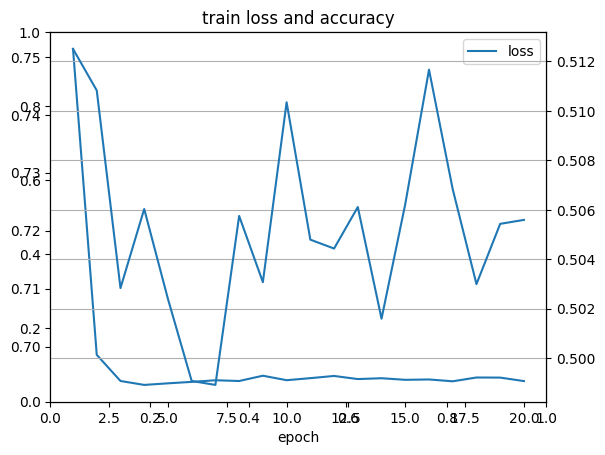

In [37]:
l, acc = [a.cpu().detach().numpy() for a in losses], accuracy
fig = plt.figure()
plt.title('train loss and accuracy')
x = np.arange(1, num_epochs + 1)
ax = fig.add_subplot(111)
ax.plot(x, l, label='loss')
ax2 = ax.twinx()
ax2.plot(x, acc, label='train_accuracy')
ax.legend()
ax.set_xlabel('epoch')
plt.grid()
plt.show()

In [ ]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
losses = np.random.rand(num_epochs)
train = np.ones(num_epochs) * 0.5
plt.plot(epochs, losses, 'r-.', label='loss')
plt.plot(epochs, train, 'c-', label='train_acc')

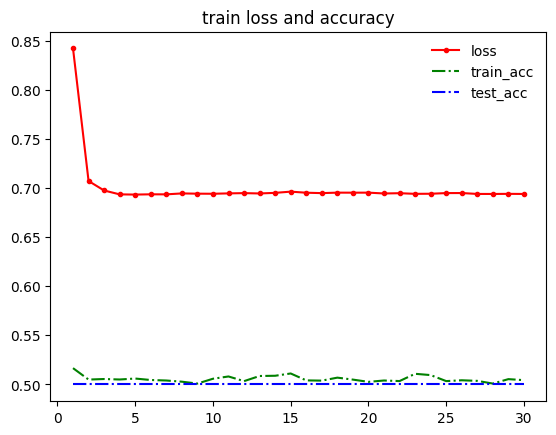

In [39]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.legend(loc='best', frameon=False)
plt.show()

# 训练1(激活函数ReLU)

In [27]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 24,492,514 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
# animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#         legend=['train loss', 'train acc'])
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    # metric = d2l.Accumulator(4)
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        # metric.add(l.sum(), d2l.accuracy(net(X, valid_len), y), labels.shape[0])
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f} '
     f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} s')

100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 1, loss 0.655, train_acc 0.622, test_acc 0.809, taking 133 seconds


100%|██████████| 391/391 [01:46<00:00,  3.69it/s]


epoch 2, loss 0.440, train_acc 0.804, test_acc 0.836, taking 134 seconds


100%|██████████| 391/391 [01:45<00:00,  3.71it/s]


epoch 3, loss 0.392, train_acc 0.830, test_acc 0.812, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 4, loss 0.376, train_acc 0.841, test_acc 0.852, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 5, loss 0.357, train_acc 0.849, test_acc 0.859, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 6, loss 0.335, train_acc 0.860, test_acc 0.856, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.71it/s]


epoch 7, loss 0.317, train_acc 0.870, test_acc 0.860, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 8, loss 0.312, train_acc 0.870, test_acc 0.864, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 9, loss 0.300, train_acc 0.877, test_acc 0.864, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 10, loss 0.288, train_acc 0.884, test_acc 0.865, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 11, loss 0.273, train_acc 0.886, test_acc 0.867, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 12, loss 0.271, train_acc 0.892, test_acc 0.867, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 13, loss 0.256, train_acc 0.900, test_acc 0.862, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 14, loss 0.241, train_acc 0.905, test_acc 0.869, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 15, loss 0.235, train_acc 0.909, test_acc 0.854, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 16, loss 0.207, train_acc 0.920, test_acc 0.834, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.70it/s]


epoch 17, loss 0.193, train_acc 0.925, test_acc 0.864, taking 133 seconds


100%|██████████| 391/391 [01:46<00:00,  3.69it/s]


epoch 18, loss 0.185, train_acc 0.931, test_acc 0.858, taking 134 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 19, loss 0.190, train_acc 0.928, test_acc 0.855, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 20, loss 0.162, train_acc 0.940, test_acc 0.835, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 21, loss 0.141, train_acc 0.949, test_acc 0.840, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 22, loss 0.139, train_acc 0.949, test_acc 0.856, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.76it/s]


epoch 23, loss 0.128, train_acc 0.953, test_acc 0.853, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 24, loss 0.117, train_acc 0.957, test_acc 0.843, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 25, loss 0.109, train_acc 0.961, test_acc 0.828, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.70it/s]


epoch 26, loss 0.103, train_acc 0.965, test_acc 0.846, taking 133 seconds


100%|██████████| 391/391 [01:46<00:00,  3.67it/s]


epoch 27, loss 0.095, train_acc 0.966, test_acc 0.825, taking 134 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 28, loss 0.089, train_acc 0.971, test_acc 0.835, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 29, loss 0.082, train_acc 0.970, test_acc 0.844, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 30, loss 0.080, train_acc 0.972, test_acc 0.833, taking 132 seconds


100%|██████████| 391/391 [01:46<00:00,  3.68it/s]


epoch 31, loss 0.077, train_acc 0.974, test_acc 0.842, taking 134 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 32, loss 0.071, train_acc 0.973, test_acc 0.820, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 33, loss 0.064, train_acc 0.977, test_acc 0.826, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 34, loss 0.063, train_acc 0.978, test_acc 0.843, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 35, loss 0.058, train_acc 0.980, test_acc 0.830, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 36, loss 0.057, train_acc 0.979, test_acc 0.828, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 37, loss 0.054, train_acc 0.981, test_acc 0.819, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 38, loss 0.051, train_acc 0.981, test_acc 0.839, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 39, loss 0.055, train_acc 0.979, test_acc 0.830, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 40, loss 0.047, train_acc 0.982, test_acc 0.816, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 41, loss 0.047, train_acc 0.985, test_acc 0.827, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 42, loss 0.042, train_acc 0.985, test_acc 0.818, taking 132 seconds


100%|██████████| 391/391 [01:46<00:00,  3.68it/s]


epoch 43, loss 0.050, train_acc 0.980, test_acc 0.821, taking 134 seconds


100%|██████████| 391/391 [01:46<00:00,  3.68it/s]


epoch 44, loss 0.041, train_acc 0.984, test_acc 0.802, taking 134 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 45, loss 0.044, train_acc 0.984, test_acc 0.835, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.70it/s]


epoch 46, loss 0.039, train_acc 0.986, test_acc 0.831, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.76it/s]


epoch 47, loss 0.036, train_acc 0.987, test_acc 0.822, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 48, loss 0.037, train_acc 0.987, test_acc 0.797, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 49, loss 0.034, train_acc 0.987, test_acc 0.828, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 50, loss 0.035, train_acc 0.987, test_acc 0.827, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 51, loss 0.027, train_acc 0.989, test_acc 0.819, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 52, loss 0.031, train_acc 0.990, test_acc 0.835, taking 133 seconds


100%|██████████| 391/391 [01:43<00:00,  3.76it/s]


epoch 53, loss 0.026, train_acc 0.990, test_acc 0.828, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 54, loss 0.028, train_acc 0.990, test_acc 0.838, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 55, loss 0.028, train_acc 0.990, test_acc 0.817, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 56, loss 0.024, train_acc 0.991, test_acc 0.819, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 57, loss 0.026, train_acc 0.990, test_acc 0.824, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.70it/s]


epoch 58, loss 0.027, train_acc 0.990, test_acc 0.811, taking 134 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 59, loss 0.023, train_acc 0.991, test_acc 0.812, taking 132 seconds


100%|██████████| 391/391 [01:46<00:00,  3.68it/s]


epoch 60, loss 0.021, train_acc 0.991, test_acc 0.807, taking 134 seconds
Training is finished.
训练损失:0.021, 训练集准确率:0.991, 测试集准确率:0.807 在设备cuda:0上训练60周期 耗时7953 s


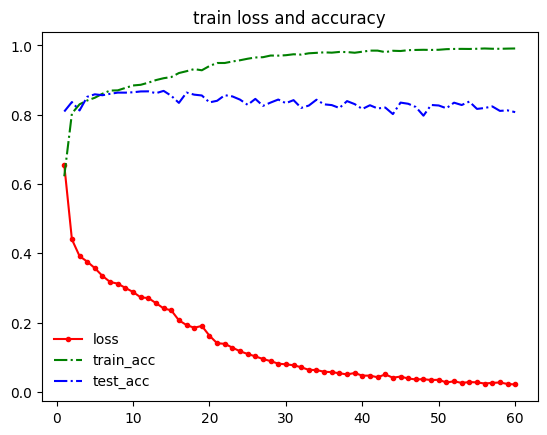

In [28]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.legend(loc='best', frameon=False)
plt.show()

In [58]:
def predict(sentence, net, vocab,):
    words = preprocess(sentence)
    tokens = ['cls'] + [word for word in words.split(' ') if word not in set(',.?!')]
    tensor = torch.tensor(d2l.truncate_pad(vocab[tokens], num_steps, vocab['<pad>'])).reshape(1, -1)
    valid_len = (tensor != vocab['<pad>']).sum(1)
    print(len(tokens), tensor.shape, valid_len.shape)
    # print(tokens, tensor, valid_len)
    device = next(iter(net.parameters())).device
    tensor, valid_len = tensor.to(device), valid_len.to(device)
    label_1, label_0 = nn.functional.softmax(net(tensor, valid_len), dim=-1).cpu().detach().reshape(-1).numpy().tolist()
    print("标签为1的概率为{:.3f}，为0的概率为{:.3f}".format(label_1, label_0))
    return label_1, label_0

sen = 'I like this movie.'
predict(sen, net, vocab)

5 torch.Size([1, 500]) torch.Size([1])
标签为1的概率为0.019，为0的概率为0.981


(0.019334016367793083, 0.9806659817695618)

In [61]:
sen = 'I love this movie.'
predict(sen, net, vocab)

5 torch.Size([1, 500]) torch.Size([1])
标签为1的概率为0.011，为0的概率为0.989


(0.011050841771066189, 0.988949179649353)

# 训练2(激活函数Tanh)

In [18]:
# 以‘微调’的模式进行训练
# activation function: nn.Tanh()
# 24,492,514 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
# animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#         legend=['train loss', 'train acc'])
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    # metric = d2l.Accumulator(4)
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        # metric.add(l.sum(), d2l.accuracy(net(X, valid_len), y), labels.shape[0])
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f} '
     f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} s')

100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


epoch 1, loss 0.733, train_acc 0.508, test_acc 0.500, taking 145 seconds


100%|██████████| 391/391 [01:55<00:00,  3.39it/s]


epoch 2, loss 0.630, train_acc 0.623, test_acc 0.763, taking 146 seconds


100%|██████████| 391/391 [01:54<00:00,  3.41it/s]


epoch 3, loss 0.471, train_acc 0.783, test_acc 0.764, taking 146 seconds


100%|██████████| 391/391 [01:53<00:00,  3.43it/s]


epoch 4, loss 0.437, train_acc 0.802, test_acc 0.817, taking 144 seconds


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


epoch 5, loss 0.399, train_acc 0.827, test_acc 0.845, taking 144 seconds


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


epoch 6, loss 0.391, train_acc 0.830, test_acc 0.845, taking 144 seconds


100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


epoch 7, loss 0.372, train_acc 0.839, test_acc 0.842, taking 146 seconds


100%|██████████| 391/391 [01:54<00:00,  3.41it/s]


epoch 8, loss 0.359, train_acc 0.849, test_acc 0.851, taking 144 seconds


100%|██████████| 391/391 [01:54<00:00,  3.43it/s]


epoch 9, loss 0.354, train_acc 0.852, test_acc 0.837, taking 145 seconds


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


epoch 10, loss 0.339, train_acc 0.857, test_acc 0.840, taking 144 seconds


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


epoch 11, loss 0.337, train_acc 0.858, test_acc 0.853, taking 144 seconds


100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


epoch 12, loss 0.325, train_acc 0.863, test_acc 0.854, taking 146 seconds


100%|██████████| 391/391 [01:55<00:00,  3.38it/s]


epoch 13, loss 0.319, train_acc 0.867, test_acc 0.847, taking 146 seconds


100%|██████████| 391/391 [01:55<00:00,  3.40it/s]


epoch 14, loss 0.308, train_acc 0.875, test_acc 0.861, taking 145 seconds


100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


epoch 15, loss 0.286, train_acc 0.886, test_acc 0.866, taking 145 seconds


100%|██████████| 391/391 [01:54<00:00,  3.40it/s]


epoch 16, loss 0.276, train_acc 0.890, test_acc 0.864, taking 146 seconds


100%|██████████| 391/391 [01:55<00:00,  3.39it/s]


epoch 17, loss 0.262, train_acc 0.895, test_acc 0.856, taking 146 seconds


100%|██████████| 391/391 [01:55<00:00,  3.38it/s]


epoch 18, loss 0.256, train_acc 0.902, test_acc 0.859, taking 146 seconds


100%|██████████| 391/391 [01:54<00:00,  3.40it/s]


epoch 19, loss 0.237, train_acc 0.907, test_acc 0.860, taking 146 seconds


100%|██████████| 391/391 [01:54<00:00,  3.41it/s]


epoch 20, loss 0.232, train_acc 0.911, test_acc 0.850, taking 146 seconds


100%|██████████| 391/391 [01:54<00:00,  3.41it/s]


epoch 21, loss 0.214, train_acc 0.919, test_acc 0.839, taking 145 seconds


100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


epoch 22, loss 0.205, train_acc 0.920, test_acc 0.850, taking 144 seconds


100%|██████████| 391/391 [01:54<00:00,  3.43it/s]


epoch 23, loss 0.189, train_acc 0.926, test_acc 0.834, taking 144 seconds


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


epoch 24, loss 0.190, train_acc 0.927, test_acc 0.852, taking 143 seconds


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


epoch 25, loss 0.183, train_acc 0.932, test_acc 0.836, taking 144 seconds


100%|██████████| 391/391 [01:53<00:00,  3.46it/s]


epoch 26, loss 0.175, train_acc 0.935, test_acc 0.844, taking 144 seconds


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


epoch 27, loss 0.167, train_acc 0.939, test_acc 0.825, taking 144 seconds


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


epoch 28, loss 0.158, train_acc 0.938, test_acc 0.827, taking 142 seconds


100%|██████████| 391/391 [01:52<00:00,  3.49it/s]


epoch 29, loss 0.150, train_acc 0.946, test_acc 0.823, taking 141 seconds


100%|██████████| 391/391 [01:53<00:00,  3.46it/s]


epoch 30, loss 0.143, train_acc 0.947, test_acc 0.825, taking 142 seconds


100%|██████████| 391/391 [01:52<00:00,  3.46it/s]


epoch 31, loss 0.131, train_acc 0.953, test_acc 0.825, taking 142 seconds


100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


epoch 32, loss 0.131, train_acc 0.951, test_acc 0.845, taking 140 seconds


100%|██████████| 391/391 [01:52<00:00,  3.46it/s]


epoch 33, loss 0.126, train_acc 0.952, test_acc 0.836, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


epoch 34, loss 0.130, train_acc 0.953, test_acc 0.831, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


epoch 35, loss 0.127, train_acc 0.953, test_acc 0.835, taking 141 seconds


100%|██████████| 391/391 [01:53<00:00,  3.46it/s]


epoch 36, loss 0.118, train_acc 0.954, test_acc 0.813, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


epoch 37, loss 0.113, train_acc 0.960, test_acc 0.834, taking 142 seconds


100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


epoch 38, loss 0.112, train_acc 0.959, test_acc 0.825, taking 141 seconds


100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


epoch 39, loss 0.103, train_acc 0.962, test_acc 0.815, taking 143 seconds


100%|██████████| 391/391 [01:52<00:00,  3.46it/s]


epoch 40, loss 0.104, train_acc 0.962, test_acc 0.820, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


epoch 41, loss 0.097, train_acc 0.966, test_acc 0.818, taking 141 seconds


100%|██████████| 391/391 [01:51<00:00,  3.49it/s]


epoch 42, loss 0.100, train_acc 0.962, test_acc 0.791, taking 140 seconds


100%|██████████| 391/391 [01:51<00:00,  3.50it/s]


epoch 43, loss 0.095, train_acc 0.965, test_acc 0.810, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


epoch 44, loss 0.091, train_acc 0.968, test_acc 0.823, taking 142 seconds


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


epoch 45, loss 0.091, train_acc 0.967, test_acc 0.826, taking 142 seconds


100%|██████████| 391/391 [01:51<00:00,  3.51it/s]


epoch 46, loss 0.085, train_acc 0.970, test_acc 0.820, taking 140 seconds


100%|██████████| 391/391 [01:51<00:00,  3.49it/s]


epoch 47, loss 0.079, train_acc 0.972, test_acc 0.819, taking 140 seconds


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


epoch 48, loss 0.081, train_acc 0.972, test_acc 0.821, taking 142 seconds


100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


epoch 49, loss 0.083, train_acc 0.968, test_acc 0.818, taking 141 seconds


100%|██████████| 391/391 [01:51<00:00,  3.49it/s]


epoch 50, loss 0.078, train_acc 0.970, test_acc 0.807, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


epoch 51, loss 0.073, train_acc 0.974, test_acc 0.831, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.49it/s]


epoch 52, loss 0.068, train_acc 0.975, test_acc 0.830, taking 140 seconds


100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


epoch 53, loss 0.071, train_acc 0.974, test_acc 0.818, taking 143 seconds


100%|██████████| 391/391 [01:50<00:00,  3.53it/s]


epoch 54, loss 0.063, train_acc 0.977, test_acc 0.837, taking 139 seconds


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


epoch 55, loss 0.064, train_acc 0.978, test_acc 0.821, taking 139 seconds


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


epoch 56, loss 0.065, train_acc 0.976, test_acc 0.810, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


epoch 57, loss 0.066, train_acc 0.977, test_acc 0.820, taking 138 seconds


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


epoch 58, loss 0.058, train_acc 0.978, test_acc 0.806, taking 137 seconds


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


epoch 59, loss 0.058, train_acc 0.978, test_acc 0.824, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


epoch 60, loss 0.058, train_acc 0.978, test_acc 0.814, taking 139 seconds
Training is finished.
训练损失:0.058, 训练集准确率:0.978, 测试集准确率:0.814 在设备cuda:0上训练60周期 耗时8556 s


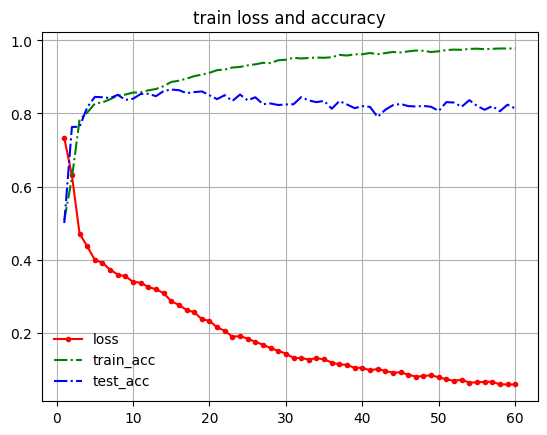

In [19]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

In [21]:
torch.save(net.state_dict(), file_path + "tanhmodel.pkl")

# 训练3(激活函数Sigmoid)

In [17]:
# 以‘微调’的模式进行训练
# activation function: nn.Sigmoid()
# 24,492,514 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
# animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#         legend=['train loss', 'train acc'])
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    # metric = d2l.Accumulator(4)
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        # metric.add(l.sum(), d2l.accuracy(net(X, valid_len), y), labels.shape[0])
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f} '
     f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} s')

100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


epoch 1, loss 0.705, train_acc 0.535, test_acc 0.640, taking 137 seconds


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


epoch 2, loss 0.605, train_acc 0.688, test_acc 0.747, taking 138 seconds


100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


epoch 3, loss 0.509, train_acc 0.761, test_acc 0.806, taking 138 seconds


100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


epoch 4, loss 0.439, train_acc 0.803, test_acc 0.833, taking 136 seconds


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


epoch 5, loss 0.397, train_acc 0.829, test_acc 0.832, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


epoch 6, loss 0.367, train_acc 0.841, test_acc 0.850, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.53it/s]


epoch 7, loss 0.358, train_acc 0.848, test_acc 0.851, taking 139 seconds


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


epoch 8, loss 0.336, train_acc 0.860, test_acc 0.858, taking 138 seconds


100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


epoch 9, loss 0.326, train_acc 0.864, test_acc 0.863, taking 137 seconds


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


epoch 10, loss 0.314, train_acc 0.870, test_acc 0.837, taking 139 seconds


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


epoch 11, loss 0.298, train_acc 0.877, test_acc 0.856, taking 137 seconds


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


epoch 12, loss 0.289, train_acc 0.882, test_acc 0.841, taking 138 seconds


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


epoch 13, loss 0.275, train_acc 0.889, test_acc 0.840, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


epoch 14, loss 0.263, train_acc 0.893, test_acc 0.869, taking 139 seconds


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


epoch 15, loss 0.256, train_acc 0.899, test_acc 0.860, taking 139 seconds


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


epoch 16, loss 0.244, train_acc 0.905, test_acc 0.869, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


epoch 17, loss 0.233, train_acc 0.910, test_acc 0.862, taking 138 seconds


100%|██████████| 391/391 [01:51<00:00,  3.52it/s]


epoch 18, loss 0.220, train_acc 0.913, test_acc 0.856, taking 140 seconds


100%|██████████| 391/391 [01:51<00:00,  3.50it/s]


epoch 19, loss 0.212, train_acc 0.919, test_acc 0.822, taking 140 seconds


100%|██████████| 391/391 [01:51<00:00,  3.52it/s]


epoch 20, loss 0.195, train_acc 0.925, test_acc 0.866, taking 140 seconds


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


epoch 21, loss 0.185, train_acc 0.932, test_acc 0.858, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.53it/s]


epoch 22, loss 0.172, train_acc 0.934, test_acc 0.854, taking 139 seconds


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


epoch 23, loss 0.162, train_acc 0.942, test_acc 0.861, taking 139 seconds


100%|██████████| 391/391 [01:48<00:00,  3.59it/s]


epoch 24, loss 0.158, train_acc 0.943, test_acc 0.851, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


epoch 25, loss 0.157, train_acc 0.942, test_acc 0.839, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.52it/s]


epoch 26, loss 0.140, train_acc 0.950, test_acc 0.855, taking 139 seconds


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


epoch 27, loss 0.132, train_acc 0.951, test_acc 0.850, taking 139 seconds


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


epoch 28, loss 0.123, train_acc 0.955, test_acc 0.848, taking 138 seconds


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


epoch 29, loss 0.117, train_acc 0.955, test_acc 0.849, taking 139 seconds


100%|██████████| 391/391 [01:51<00:00,  3.51it/s]


epoch 30, loss 0.113, train_acc 0.959, test_acc 0.849, taking 140 seconds


100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


epoch 31, loss 0.107, train_acc 0.961, test_acc 0.851, taking 137 seconds


100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


epoch 32, loss 0.100, train_acc 0.963, test_acc 0.846, taking 137 seconds


100%|██████████| 391/391 [01:47<00:00,  3.64it/s]


epoch 33, loss 0.096, train_acc 0.965, test_acc 0.849, taking 135 seconds


100%|██████████| 391/391 [01:48<00:00,  3.62it/s]


epoch 34, loss 0.093, train_acc 0.966, test_acc 0.839, taking 136 seconds


100%|██████████| 391/391 [01:46<00:00,  3.67it/s]


epoch 35, loss 0.089, train_acc 0.967, test_acc 0.841, taking 134 seconds


100%|██████████| 391/391 [01:47<00:00,  3.62it/s]


epoch 36, loss 0.087, train_acc 0.968, test_acc 0.834, taking 136 seconds


100%|██████████| 391/391 [01:51<00:00,  3.52it/s]


epoch 37, loss 0.088, train_acc 0.968, test_acc 0.835, taking 139 seconds


100%|██████████| 391/391 [01:51<00:00,  3.51it/s]


epoch 38, loss 0.083, train_acc 0.968, test_acc 0.825, taking 140 seconds


100%|██████████| 391/391 [01:50<00:00,  3.53it/s]


epoch 39, loss 0.083, train_acc 0.970, test_acc 0.846, taking 139 seconds


100%|██████████| 391/391 [01:51<00:00,  3.51it/s]


epoch 40, loss 0.086, train_acc 0.969, test_acc 0.839, taking 140 seconds


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


epoch 41, loss 0.073, train_acc 0.975, test_acc 0.834, taking 139 seconds


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


epoch 42, loss 0.076, train_acc 0.974, test_acc 0.843, taking 138 seconds


100%|██████████| 391/391 [01:51<00:00,  3.51it/s]


epoch 43, loss 0.075, train_acc 0.973, test_acc 0.830, taking 140 seconds


100%|██████████| 391/391 [01:51<00:00,  3.49it/s]


epoch 44, loss 0.072, train_acc 0.973, test_acc 0.845, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


epoch 45, loss 0.066, train_acc 0.975, test_acc 0.816, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.49it/s]


epoch 46, loss 0.065, train_acc 0.977, test_acc 0.843, taking 141 seconds


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


epoch 47, loss 0.062, train_acc 0.978, test_acc 0.827, taking 142 seconds


100%|██████████| 391/391 [01:53<00:00,  3.46it/s]


epoch 48, loss 0.061, train_acc 0.979, test_acc 0.835, taking 142 seconds


100%|██████████| 391/391 [01:52<00:00,  3.46it/s]


epoch 49, loss 0.053, train_acc 0.980, test_acc 0.843, taking 141 seconds


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


epoch 50, loss 0.059, train_acc 0.979, test_acc 0.842, taking 138 seconds


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


epoch 51, loss 0.048, train_acc 0.982, test_acc 0.835, taking 138 seconds


100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


epoch 52, loss 0.051, train_acc 0.980, test_acc 0.843, taking 137 seconds


100%|██████████| 391/391 [01:48<00:00,  3.59it/s]


epoch 53, loss 0.053, train_acc 0.980, test_acc 0.848, taking 137 seconds


100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


epoch 54, loss 0.055, train_acc 0.981, test_acc 0.836, taking 136 seconds


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


epoch 55, loss 0.047, train_acc 0.984, test_acc 0.822, taking 139 seconds


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


epoch 56, loss 0.046, train_acc 0.984, test_acc 0.848, taking 138 seconds


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


epoch 57, loss 0.048, train_acc 0.982, test_acc 0.819, taking 138 seconds


100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


epoch 58, loss 0.047, train_acc 0.982, test_acc 0.836, taking 137 seconds


100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


epoch 59, loss 0.043, train_acc 0.985, test_acc 0.827, taking 137 seconds


100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


epoch 60, loss 0.045, train_acc 0.985, test_acc 0.821, taking 137 seconds
Training is finished.
训练损失:0.045, 训练集准确率:0.985, 测试集准确率:0.821 在设备cuda:0上训练60周期 耗时8301 s


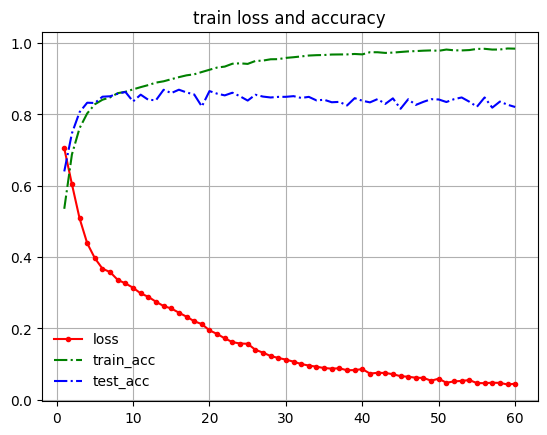

In [18]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

In [19]:
torch.save(net.state_dict(), file_path + "sigmoidhmodel.pkl")

# 训练4(单层编码器)

In [ ]:
from torchsummary import summary
summary(net, input_size=[(1, 500), (1,)], batch_size=2, device='cpu')

In [34]:
# 以‘微调’的模式进行训练，单层编码器块
# 22,017,010 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': forward_params},
    {'params': net.embedding.parameters(),
    'lr': lr * 0.01}], lr=lr)
# animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#         legend=['train loss', 'train acc'])
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    # metric = d2l.Accumulator(4)
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        # metric.add(l.sum(), d2l.accuracy(net(X, valid_len), y), labels.shape[0])
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f}'
     f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost}s')

100%|██████████| 391/391 [01:02<00:00,  6.21it/s]


epoch 1, loss 0.698, train_acc 0.508, test_acc 0.556, taking 79 seconds


100%|██████████| 391/391 [01:01<00:00,  6.40it/s]


epoch 2, loss 0.691, train_acc 0.532, test_acc 0.575, taking 76 seconds


100%|██████████| 391/391 [01:03<00:00,  6.20it/s]


epoch 3, loss 0.669, train_acc 0.580, test_acc 0.623, taking 79 seconds


100%|██████████| 391/391 [01:02<00:00,  6.29it/s]


epoch 4, loss 0.659, train_acc 0.598, test_acc 0.573, taking 79 seconds


100%|██████████| 391/391 [01:02<00:00,  6.25it/s]


epoch 5, loss 0.648, train_acc 0.612, test_acc 0.644, taking 79 seconds


100%|██████████| 391/391 [01:03<00:00,  6.16it/s]


epoch 6, loss 0.636, train_acc 0.627, test_acc 0.653, taking 80 seconds


100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


epoch 7, loss 0.631, train_acc 0.642, test_acc 0.651, taking 81 seconds


100%|██████████| 391/391 [01:00<00:00,  6.47it/s]


epoch 8, loss 0.626, train_acc 0.646, test_acc 0.669, taking 77 seconds


100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


epoch 9, loss 0.622, train_acc 0.648, test_acc 0.677, taking 81 seconds


100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


epoch 10, loss 0.619, train_acc 0.652, test_acc 0.673, taking 76 seconds


100%|██████████| 391/391 [01:02<00:00,  6.30it/s]


epoch 11, loss 0.612, train_acc 0.663, test_acc 0.673, taking 83 seconds


100%|██████████| 391/391 [01:00<00:00,  6.46it/s]


epoch 12, loss 0.608, train_acc 0.670, test_acc 0.695, taking 76 seconds


100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


epoch 13, loss 0.602, train_acc 0.669, test_acc 0.696, taking 77 seconds


100%|██████████| 391/391 [01:00<00:00,  6.45it/s]


epoch 14, loss 0.597, train_acc 0.678, test_acc 0.690, taking 84 seconds


100%|██████████| 391/391 [01:00<00:00,  6.42it/s]


epoch 15, loss 0.592, train_acc 0.681, test_acc 0.707, taking 77 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 16, loss 0.584, train_acc 0.693, test_acc 0.722, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 17, loss 0.562, train_acc 0.710, test_acc 0.737, taking 73 seconds


100%|██████████| 391/391 [01:03<00:00,  6.16it/s]


epoch 18, loss 0.537, train_acc 0.732, test_acc 0.746, taking 78 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 19, loss 0.524, train_acc 0.740, test_acc 0.774, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 20, loss 0.517, train_acc 0.741, test_acc 0.781, taking 73 seconds


100%|██████████| 391/391 [01:00<00:00,  6.47it/s]


epoch 21, loss 0.514, train_acc 0.743, test_acc 0.783, taking 75 seconds


100%|██████████| 391/391 [01:05<00:00,  6.00it/s]


epoch 22, loss 0.509, train_acc 0.751, test_acc 0.784, taking 80 seconds


100%|██████████| 391/391 [00:57<00:00,  6.74it/s]


epoch 23, loss 0.506, train_acc 0.754, test_acc 0.787, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


epoch 24, loss 0.501, train_acc 0.758, test_acc 0.787, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


epoch 25, loss 0.498, train_acc 0.760, test_acc 0.789, taking 72 seconds


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


epoch 26, loss 0.499, train_acc 0.753, test_acc 0.788, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 27, loss 0.494, train_acc 0.765, test_acc 0.791, taking 82 seconds


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


epoch 28, loss 0.491, train_acc 0.765, test_acc 0.795, taking 72 seconds


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


epoch 29, loss 0.485, train_acc 0.765, test_acc 0.793, taking 72 seconds


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


epoch 30, loss 0.487, train_acc 0.767, test_acc 0.789, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


epoch 31, loss 0.480, train_acc 0.767, test_acc 0.788, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 32, loss 0.481, train_acc 0.769, test_acc 0.796, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


epoch 33, loss 0.485, train_acc 0.767, test_acc 0.798, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 34, loss 0.479, train_acc 0.770, test_acc 0.798, taking 83 seconds


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


epoch 35, loss 0.475, train_acc 0.768, test_acc 0.797, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


epoch 36, loss 0.476, train_acc 0.775, test_acc 0.795, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 37, loss 0.475, train_acc 0.774, test_acc 0.797, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.83it/s]


epoch 38, loss 0.475, train_acc 0.773, test_acc 0.799, taking 72 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 39, loss 0.475, train_acc 0.774, test_acc 0.795, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


epoch 40, loss 0.474, train_acc 0.776, test_acc 0.800, taking 73 seconds


100%|██████████| 391/391 [01:04<00:00,  6.10it/s]


epoch 41, loss 0.469, train_acc 0.775, test_acc 0.792, taking 79 seconds


100%|██████████| 391/391 [00:57<00:00,  6.74it/s]


epoch 42, loss 0.470, train_acc 0.774, test_acc 0.801, taking 73 seconds


100%|██████████| 391/391 [01:10<00:00,  5.52it/s]


epoch 43, loss 0.470, train_acc 0.778, test_acc 0.798, taking 86 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 44, loss 0.472, train_acc 0.774, test_acc 0.801, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


epoch 45, loss 0.466, train_acc 0.779, test_acc 0.800, taking 72 seconds


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


epoch 46, loss 0.470, train_acc 0.777, test_acc 0.802, taking 72 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 47, loss 0.469, train_acc 0.780, test_acc 0.804, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.70it/s]


epoch 48, loss 0.464, train_acc 0.778, test_acc 0.803, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.70it/s]


epoch 49, loss 0.468, train_acc 0.780, test_acc 0.802, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.68it/s]


epoch 50, loss 0.468, train_acc 0.778, test_acc 0.804, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 51, loss 0.464, train_acc 0.780, test_acc 0.804, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.66it/s]


epoch 52, loss 0.466, train_acc 0.780, test_acc 0.802, taking 74 seconds


100%|██████████| 391/391 [00:59<00:00,  6.58it/s]


epoch 53, loss 0.468, train_acc 0.784, test_acc 0.806, taking 94 seconds


100%|██████████| 391/391 [00:59<00:00,  6.56it/s]


epoch 54, loss 0.467, train_acc 0.779, test_acc 0.804, taking 75 seconds


100%|██████████| 391/391 [00:58<00:00,  6.68it/s]


epoch 55, loss 0.460, train_acc 0.783, test_acc 0.805, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 56, loss 0.460, train_acc 0.784, test_acc 0.807, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


epoch 57, loss 0.460, train_acc 0.783, test_acc 0.807, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.68it/s]


epoch 58, loss 0.457, train_acc 0.781, test_acc 0.806, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 59, loss 0.460, train_acc 0.782, test_acc 0.807, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 60, loss 0.461, train_acc 0.782, test_acc 0.808, taking 74 seconds
Training is finished.
训练损失:0.461, 训练集准确率:0.782, 测试集准确率:0.808在设备cuda:0上训练60周期 耗时4545s


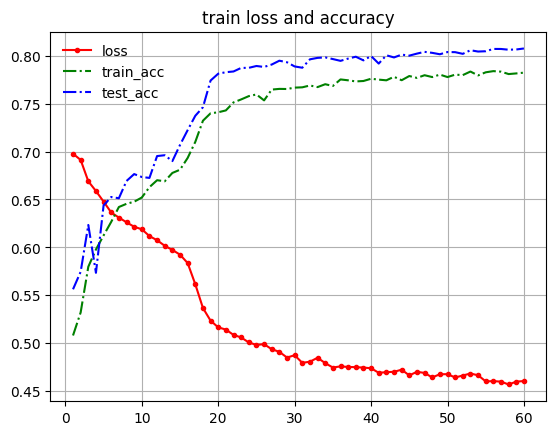

In [35]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

# 训练5(使用卷积)

In [27]:
# 模型和模型参数数量
net = TransformerEncoder(
    len(vocab), num_hiddens, norm_shape,
    ffn_num_input, ffn_num_hiddens, dim_dict,
    num_layers,dropout, num_output, kernel_size, stride)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

21,756,091 total parameters.
21,756,091 training parameters.


In [19]:
X = torch.ones((64, 500), dtype=torch.int32)
valid_len = torch.ones(64, dtype=torch.int32)
type(valid_len)
net(X, valid_len).shape

torch.Size([64, 2])

In [24]:
num_epochs = 30

In [30]:
# 以‘微调’的模式进行训练
# 21,756,091 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
# animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#         legend=['train loss', 'train acc'])
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    # metric = d2l.Accumulator(4)
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        # metric.add(l.sum(), d2l.accuracy(net(X, valid_len), y), labels.shape[0])
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f}'
     f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost}s')

100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 1, loss 0.694, train_acc 0.500, test_acc 0.500, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.66it/s]


epoch 2, loss 0.693, train_acc 0.500, test_acc 0.500, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


epoch 3, loss 0.693, train_acc 0.495, test_acc 0.500, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


epoch 4, loss 0.693, train_acc 0.498, test_acc 0.500, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 5, loss 0.693, train_acc 0.497, test_acc 0.500, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 6, loss 0.692, train_acc 0.494, test_acc 0.500, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 7, loss 0.693, train_acc 0.500, test_acc 0.500, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


epoch 8, loss 0.693, train_acc 0.500, test_acc 0.500, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.74it/s]


epoch 9, loss 0.693, train_acc 0.499, test_acc 0.500, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 10, loss 0.693, train_acc 0.496, test_acc 0.500, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.68it/s]


epoch 11, loss 0.693, train_acc 0.493, test_acc 0.500, taking 74 seconds


100%|██████████| 391/391 [00:57<00:00,  6.79it/s]


epoch 12, loss 0.693, train_acc 0.498, test_acc 0.500, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.70it/s]


epoch 13, loss 0.693, train_acc 0.498, test_acc 0.500, taking 74 seconds


100%|██████████| 391/391 [00:57<00:00,  6.74it/s]


epoch 14, loss 0.693, train_acc 0.492, test_acc 0.500, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.81it/s]


epoch 15, loss 0.693, train_acc 0.496, test_acc 0.500, taking 72 seconds


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


epoch 16, loss 0.693, train_acc 0.499, test_acc 0.500, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.67it/s]


epoch 17, loss 0.693, train_acc 0.501, test_acc 0.500, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 18, loss 0.693, train_acc 0.498, test_acc 0.500, taking 73 seconds


 12%|█▏        | 45/391 [00:06<00:51,  6.68it/s]


KeyboardInterrupt: 

# 训练6(单层编码器, ReLU激活)

In [15]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 24,492,514 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
# animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#         legend=['train loss', 'train acc'])
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    # metric = d2l.Accumulator(4)
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        # metric.add(l.sum(), d2l.accuracy(net(X, valid_len), y), labels.shape[0])
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f}, '
     f'在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 391/391 [00:58<00:00,  6.67it/s]


epoch 1, loss 0.721, train_acc 0.542, test_acc 0.553, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.67it/s]


epoch 2, loss 0.617, train_acc 0.655, test_acc 0.734, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 3, loss 0.563, train_acc 0.721, test_acc 0.753, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.70it/s]


epoch 4, loss 0.550, train_acc 0.733, test_acc 0.746, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.68it/s]


epoch 5, loss 0.549, train_acc 0.733, test_acc 0.751, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.67it/s]


epoch 6, loss 0.542, train_acc 0.734, test_acc 0.744, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 7, loss 0.543, train_acc 0.730, test_acc 0.753, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.65it/s]


epoch 8, loss 0.531, train_acc 0.742, test_acc 0.749, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.68it/s]


epoch 9, loss 0.522, train_acc 0.747, test_acc 0.770, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.66it/s]


epoch 10, loss 0.519, train_acc 0.745, test_acc 0.743, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.65it/s]


epoch 11, loss 0.510, train_acc 0.757, test_acc 0.786, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.67it/s]


epoch 12, loss 0.503, train_acc 0.763, test_acc 0.779, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 13, loss 0.505, train_acc 0.759, test_acc 0.780, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.66it/s]


epoch 14, loss 0.497, train_acc 0.764, test_acc 0.783, taking 75 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 15, loss 0.497, train_acc 0.767, test_acc 0.774, taking 74 seconds


100%|██████████| 391/391 [00:59<00:00,  6.63it/s]


epoch 16, loss 0.513, train_acc 0.751, test_acc 0.772, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.64it/s]


epoch 17, loss 0.506, train_acc 0.754, test_acc 0.784, taking 74 seconds


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


epoch 18, loss 0.497, train_acc 0.765, test_acc 0.784, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


epoch 19, loss 0.495, train_acc 0.766, test_acc 0.780, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.76it/s]


epoch 20, loss 0.491, train_acc 0.769, test_acc 0.786, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


epoch 21, loss 0.487, train_acc 0.771, test_acc 0.791, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


epoch 22, loss 0.488, train_acc 0.771, test_acc 0.789, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


epoch 23, loss 0.483, train_acc 0.774, test_acc 0.786, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.78it/s]


epoch 24, loss 0.484, train_acc 0.769, test_acc 0.786, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


epoch 25, loss 0.481, train_acc 0.778, test_acc 0.788, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 26, loss 0.482, train_acc 0.774, test_acc 0.736, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 27, loss 0.558, train_acc 0.720, test_acc 0.740, taking 74 seconds


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


epoch 28, loss 0.505, train_acc 0.759, test_acc 0.794, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 29, loss 0.474, train_acc 0.781, test_acc 0.795, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 30, loss 0.476, train_acc 0.776, test_acc 0.790, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 31, loss 0.487, train_acc 0.773, test_acc 0.784, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 32, loss 0.496, train_acc 0.768, test_acc 0.785, taking 73 seconds


100%|██████████| 391/391 [00:56<00:00,  6.88it/s]


epoch 33, loss 0.494, train_acc 0.774, test_acc 0.784, taking 72 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 34, loss 0.490, train_acc 0.770, test_acc 0.787, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


epoch 35, loss 0.490, train_acc 0.773, test_acc 0.784, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 36, loss 0.487, train_acc 0.766, test_acc 0.783, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


epoch 37, loss 0.489, train_acc 0.768, test_acc 0.783, taking 72 seconds


100%|██████████| 391/391 [00:57<00:00,  6.85it/s]


epoch 38, loss 0.486, train_acc 0.774, test_acc 0.788, taking 72 seconds


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


epoch 39, loss 0.496, train_acc 0.771, test_acc 0.786, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


epoch 40, loss 0.490, train_acc 0.769, test_acc 0.787, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.86it/s]


epoch 41, loss 0.485, train_acc 0.776, test_acc 0.790, taking 72 seconds


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


epoch 42, loss 0.485, train_acc 0.780, test_acc 0.790, taking 72 seconds


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


epoch 43, loss 0.477, train_acc 0.776, test_acc 0.794, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.74it/s]


epoch 44, loss 0.467, train_acc 0.784, test_acc 0.797, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.70it/s]


epoch 45, loss 0.466, train_acc 0.784, test_acc 0.793, taking 74 seconds


100%|██████████| 391/391 [00:57<00:00,  6.74it/s]


epoch 46, loss 0.468, train_acc 0.788, test_acc 0.796, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.70it/s]


epoch 47, loss 0.469, train_acc 0.785, test_acc 0.791, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.68it/s]


epoch 48, loss 0.485, train_acc 0.774, test_acc 0.777, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 49, loss 0.502, train_acc 0.765, test_acc 0.776, taking 74 seconds


100%|██████████| 391/391 [00:58<00:00,  6.70it/s]


epoch 50, loss 0.495, train_acc 0.770, test_acc 0.779, taking 73 seconds


100%|██████████| 391/391 [00:56<00:00,  6.93it/s]


epoch 51, loss 0.501, train_acc 0.764, test_acc 0.779, taking 72 seconds


100%|██████████| 391/391 [00:57<00:00,  6.74it/s]


epoch 52, loss 0.500, train_acc 0.762, test_acc 0.775, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.77it/s]


epoch 53, loss 0.506, train_acc 0.758, test_acc 0.777, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


epoch 54, loss 0.502, train_acc 0.765, test_acc 0.780, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


epoch 55, loss 0.502, train_acc 0.763, test_acc 0.778, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.69it/s]


epoch 56, loss 0.509, train_acc 0.760, test_acc 0.778, taking 73 seconds


100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


epoch 57, loss 0.499, train_acc 0.767, test_acc 0.782, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


epoch 58, loss 0.498, train_acc 0.765, test_acc 0.781, taking 72 seconds


100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


epoch 59, loss 0.505, train_acc 0.764, test_acc 0.780, taking 73 seconds


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]


epoch 60, loss 0.500, train_acc 0.764, test_acc 0.785, taking 73 seconds
Training is finished.
训练损失:0.500, 训练集准确率:0.764, 测试集准确率:0.785 在设备cuda:0上训练60周期 耗时4391 s


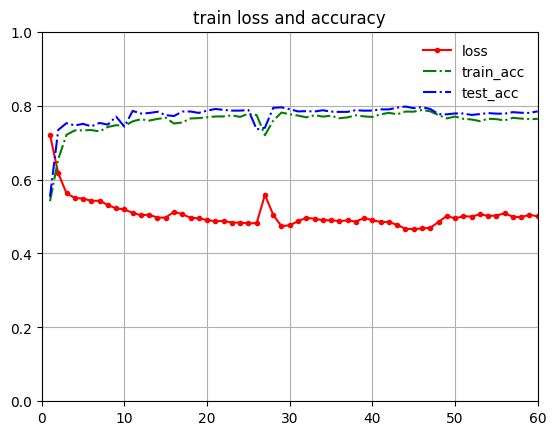

In [24]:
fig = plt.figure()
plt.title('train loss and accuracy')
plt.axis([0, 60, 0, 1])
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

In [22]:
max(train_accuracy), max(test_accuracy)

(0.7880434782608695, 0.79748)

# 对比训练1(常规多头两层)

In [8]:
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, num_output, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.outhidden = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU())
        self.Dense = nn.Linear(num_hiddens, num_output)
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                d2l.EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        # 取句首'cls'token的向量用于情感分类
        return self.Dense(self.outhidden(X[:, 0, :]))

In [13]:
num_hiddens, num_layers, dropout, batch_size, num_output = 512, 2, 0.1, 64, 2
lr, num_epochs, device = 5e-5, 60, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 512, 2048, 8
key_size, query_size, value_size = 512, 512, 512
norm_shape = [512]

In [14]:
net = TransformerEncoder(
    len(vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout, num_output)

total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

25,842,178 total parameters.
25,842,178 training parameters.


In [18]:
file_path = 'autodl-tmp/'

In [23]:
# 初始化线性层权重
def xavier_init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


net.apply(xavier_init_weights)

TransformerEncoder(
  (embedding): Embedding(37652, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=512, out_features=512, bias=False)
        (W_k): Linear(in_features=512, out_features=512, bias=False)
        (W_v): Linear(in_features=512, out_features=512, bias=False)
        (W_o): Linear(in_features=512, out_features=512, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=512, out_features=2048, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (addnorm2): AddNo

In [24]:
num_epochs = 40

In [25]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 25,842,178 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
# animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#         legend=['train loss', 'train acc'])
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    # metric = d2l.Accumulator(4)
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        # metric.add(l.sum(), d2l.accuracy(net(X, valid_len), y), labels.shape[0])
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f} '
     f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} s')

100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


epoch 1, loss 0.731, train_acc 0.525, test_acc 0.498, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


epoch 2, loss 0.614, train_acc 0.663, test_acc 0.740, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.15it/s]


epoch 3, loss 0.538, train_acc 0.749, test_acc 0.581, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 4, loss 0.518, train_acc 0.761, test_acc 0.768, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.15it/s]


epoch 5, loss 0.507, train_acc 0.767, test_acc 0.785, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 6, loss 0.501, train_acc 0.768, test_acc 0.742, taking 94 seconds


100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


epoch 7, loss 0.508, train_acc 0.765, test_acc 0.738, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.10it/s]


epoch 8, loss 0.492, train_acc 0.774, test_acc 0.773, taking 96 seconds


100%|██████████| 391/391 [01:16<00:00,  5.11it/s]


epoch 9, loss 0.484, train_acc 0.776, test_acc 0.785, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.11it/s]


epoch 10, loss 0.480, train_acc 0.780, test_acc 0.768, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


epoch 11, loss 0.475, train_acc 0.780, test_acc 0.782, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.11it/s]


epoch 12, loss 0.464, train_acc 0.787, test_acc 0.783, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


epoch 13, loss 0.460, train_acc 0.789, test_acc 0.791, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


epoch 14, loss 0.463, train_acc 0.788, test_acc 0.753, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 15, loss 0.459, train_acc 0.790, test_acc 0.790, taking 94 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 16, loss 0.453, train_acc 0.793, test_acc 0.793, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.14it/s]


epoch 17, loss 0.452, train_acc 0.795, test_acc 0.775, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 18, loss 0.461, train_acc 0.786, test_acc 0.767, taking 94 seconds


100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


epoch 19, loss 0.452, train_acc 0.792, test_acc 0.791, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 20, loss 0.460, train_acc 0.791, test_acc 0.770, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.15it/s]


epoch 21, loss 0.458, train_acc 0.790, test_acc 0.794, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 22, loss 0.450, train_acc 0.800, test_acc 0.786, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.15it/s]


epoch 23, loss 0.458, train_acc 0.791, test_acc 0.780, taking 95 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 24, loss 0.461, train_acc 0.787, test_acc 0.783, taking 94 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 25, loss 0.458, train_acc 0.792, test_acc 0.789, taking 94 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 26, loss 0.456, train_acc 0.794, test_acc 0.787, taking 94 seconds


100%|██████████| 391/391 [01:15<00:00,  5.17it/s]


epoch 27, loss 0.468, train_acc 0.792, test_acc 0.787, taking 94 seconds


100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


epoch 28, loss 0.467, train_acc 0.786, test_acc 0.788, taking 94 seconds


100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


epoch 29, loss 0.456, train_acc 0.794, test_acc 0.786, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.10it/s]


epoch 30, loss 0.457, train_acc 0.791, test_acc 0.785, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


epoch 31, loss 0.457, train_acc 0.795, test_acc 0.791, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.11it/s]


epoch 32, loss 0.448, train_acc 0.799, test_acc 0.789, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.10it/s]


epoch 33, loss 0.450, train_acc 0.796, test_acc 0.784, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.10it/s]


epoch 34, loss 0.459, train_acc 0.792, test_acc 0.788, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.10it/s]


epoch 35, loss 0.447, train_acc 0.801, test_acc 0.794, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


epoch 36, loss 0.432, train_acc 0.805, test_acc 0.796, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.10it/s]


epoch 37, loss 0.426, train_acc 0.806, test_acc 0.804, taking 95 seconds


100%|██████████| 391/391 [01:16<00:00,  5.09it/s]


epoch 38, loss 0.435, train_acc 0.807, test_acc 0.798, taking 96 seconds


100%|██████████| 391/391 [01:16<00:00,  5.09it/s]


epoch 39, loss 0.435, train_acc 0.805, test_acc 0.784, taking 96 seconds


100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


epoch 40, loss 0.454, train_acc 0.794, test_acc 0.779, taking 95 seconds
Training is finished.
训练损失:0.454, 训练集准确率:0.794, 测试集准确率:0.779 在设备cuda:0上训练40周期 耗时3797 s


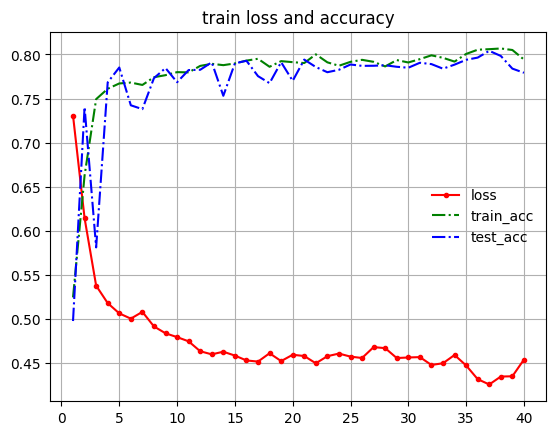

In [26]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()

# 对比训练2(常规多头一层)

In [15]:
num_hiddens, num_layers, dropout, batch_size, num_output = 512, 1, 0.1, 64, 2
lr, num_epochs, device = 5e-5, 60, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 512, 2048, 8
key_size, query_size, value_size = 512, 512, 512
norm_shape = [512]

In [16]:
net = TransformerEncoder(
    len(vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout, num_output)

total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

22,691,842 total parameters.
22,691,842 training parameters.


In [19]:
# 初始化embedding层模型权重
def get_embedding_weights(vocab, word2vecmodel, num_hiddens):
    wordlist = word2vecmodel.wv.index_to_key
    n = len(vocab)
    data = np.random.randn(n, num_hiddens)
    for i in range(n):
        word = vocab.idx_to_token[i]
        data[i] = np.array(word2vecmodel.wv[word]) if word in wordlist else data[i]
    return torch.tensor(data, dtype=torch.float32)


def init_embedding_weights(net, weights):
    for m in net.modules():
        if isinstance(m, nn.Embedding):
            m.weight.data = weights


word2vecmodel = word2vec.Word2Vec.load(file_path + 'imdb_word_vec_sg.bin')
weights = get_embedding_weights(vocab, word2vecmodel, num_hiddens)
init_embedding_weights(net, weights)

In [20]:
# 初始化线性层权重
def xavier_init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


net.apply(xavier_init_weights)

TransformerEncoder(
  (embedding): Embedding(37652, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=512, out_features=512, bias=False)
        (W_k): Linear(in_features=512, out_features=512, bias=False)
        (W_v): Linear(in_features=512, out_features=512, bias=False)
        (W_o): Linear(in_features=512, out_features=512, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=512, out_features=2048, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (addnorm2): AddNo

In [22]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 22,691,842 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
# animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#         legend=['train loss', 'train acc'])
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    # metric = d2l.Accumulator(4)
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        # metric.add(l.sum(), d2l.accuracy(net(X, valid_len), y), labels.shape[0])
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f} '
     f'在设备{device}上训练{num_epochs}周期 耗时{total_timecost} s')

100%|██████████| 391/391 [00:38<00:00, 10.07it/s]


epoch 1, loss 0.733, train_acc 0.532, test_acc 0.660, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.08it/s]


epoch 2, loss 0.650, train_acc 0.622, test_acc 0.506, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.07it/s]


epoch 3, loss 0.685, train_acc 0.552, test_acc 0.500, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.07it/s]


epoch 4, loss 0.683, train_acc 0.559, test_acc 0.586, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.03it/s]


epoch 5, loss 0.665, train_acc 0.592, test_acc 0.613, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 6, loss 0.633, train_acc 0.634, test_acc 0.661, taking 48 seconds


100%|██████████| 391/391 [00:39<00:00, 10.02it/s]


epoch 7, loss 0.626, train_acc 0.649, test_acc 0.679, taking 49 seconds


100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


epoch 8, loss 0.577, train_acc 0.705, test_acc 0.746, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


epoch 9, loss 0.566, train_acc 0.704, test_acc 0.767, taking 48 seconds


100%|██████████| 391/391 [00:39<00:00, 10.01it/s]


epoch 10, loss 0.510, train_acc 0.753, test_acc 0.772, taking 49 seconds


100%|██████████| 391/391 [00:39<00:00, 10.03it/s]


epoch 11, loss 0.508, train_acc 0.756, test_acc 0.773, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.03it/s]


epoch 12, loss 0.513, train_acc 0.754, test_acc 0.766, taking 48 seconds


100%|██████████| 391/391 [00:39<00:00, 10.01it/s]


epoch 13, loss 0.508, train_acc 0.751, test_acc 0.760, taking 49 seconds


100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


epoch 14, loss 0.505, train_acc 0.759, test_acc 0.774, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.07it/s]


epoch 15, loss 0.496, train_acc 0.765, test_acc 0.773, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.03it/s]


epoch 16, loss 0.491, train_acc 0.765, test_acc 0.778, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


epoch 17, loss 0.484, train_acc 0.770, test_acc 0.780, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 18, loss 0.531, train_acc 0.739, test_acc 0.765, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 19, loss 0.524, train_acc 0.748, test_acc 0.763, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 20, loss 0.511, train_acc 0.752, test_acc 0.765, taking 48 seconds


100%|██████████| 391/391 [00:39<00:00, 10.01it/s]


epoch 21, loss 0.504, train_acc 0.752, test_acc 0.765, taking 49 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 22, loss 0.504, train_acc 0.755, test_acc 0.769, taking 48 seconds


100%|██████████| 391/391 [00:39<00:00, 10.01it/s]


epoch 23, loss 0.502, train_acc 0.758, test_acc 0.773, taking 49 seconds


100%|██████████| 391/391 [00:38<00:00, 10.07it/s]


epoch 24, loss 0.501, train_acc 0.760, test_acc 0.774, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 25, loss 0.507, train_acc 0.752, test_acc 0.764, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.04it/s]


epoch 26, loss 0.507, train_acc 0.750, test_acc 0.757, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 27, loss 0.508, train_acc 0.750, test_acc 0.766, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 28, loss 0.505, train_acc 0.750, test_acc 0.771, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.03it/s]


epoch 29, loss 0.501, train_acc 0.753, test_acc 0.764, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.03it/s]


epoch 30, loss 0.509, train_acc 0.759, test_acc 0.778, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.03it/s]


epoch 31, loss 0.505, train_acc 0.762, test_acc 0.773, taking 48 seconds


100%|██████████| 391/391 [00:39<00:00, 10.01it/s]


epoch 32, loss 0.502, train_acc 0.762, test_acc 0.775, taking 49 seconds


100%|██████████| 391/391 [00:39<00:00, 10.02it/s]


epoch 33, loss 0.506, train_acc 0.754, test_acc 0.783, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.04it/s]


epoch 34, loss 0.486, train_acc 0.770, test_acc 0.780, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 35, loss 0.502, train_acc 0.761, test_acc 0.765, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.07it/s]


epoch 36, loss 0.511, train_acc 0.755, test_acc 0.772, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


epoch 37, loss 0.513, train_acc 0.754, test_acc 0.763, taking 48 seconds


100%|██████████| 391/391 [00:39<00:00,  9.96it/s]


epoch 38, loss 0.515, train_acc 0.754, test_acc 0.750, taking 49 seconds


100%|██████████| 391/391 [00:39<00:00, 10.02it/s]


epoch 39, loss 0.522, train_acc 0.742, test_acc 0.740, taking 49 seconds


100%|██████████| 391/391 [00:38<00:00, 10.04it/s]


epoch 40, loss 0.528, train_acc 0.736, test_acc 0.756, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 41, loss 0.518, train_acc 0.747, test_acc 0.752, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.09it/s]


epoch 42, loss 0.513, train_acc 0.748, test_acc 0.755, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


epoch 43, loss 0.509, train_acc 0.754, test_acc 0.758, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.07it/s]


epoch 44, loss 0.507, train_acc 0.754, test_acc 0.757, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.07it/s]


epoch 45, loss 0.503, train_acc 0.758, test_acc 0.760, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 46, loss 0.500, train_acc 0.760, test_acc 0.766, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.03it/s]


epoch 47, loss 0.485, train_acc 0.768, test_acc 0.774, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.08it/s]


epoch 48, loss 0.488, train_acc 0.768, test_acc 0.759, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.07it/s]


epoch 49, loss 0.503, train_acc 0.755, test_acc 0.757, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.04it/s]


epoch 50, loss 0.502, train_acc 0.754, test_acc 0.759, taking 48 seconds


100%|██████████| 391/391 [00:39<00:00,  9.99it/s]


epoch 51, loss 0.495, train_acc 0.755, test_acc 0.756, taking 49 seconds


100%|██████████| 391/391 [00:39<00:00, 10.02it/s]


epoch 52, loss 0.499, train_acc 0.754, test_acc 0.760, taking 49 seconds


100%|██████████| 391/391 [00:38<00:00, 10.04it/s]


epoch 53, loss 0.494, train_acc 0.762, test_acc 0.765, taking 48 seconds


100%|██████████| 391/391 [00:39<00:00,  9.98it/s]


epoch 54, loss 0.479, train_acc 0.769, test_acc 0.775, taking 49 seconds


100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


epoch 55, loss 0.481, train_acc 0.771, test_acc 0.772, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.04it/s]


epoch 56, loss 0.482, train_acc 0.767, test_acc 0.768, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.03it/s]


epoch 57, loss 0.487, train_acc 0.762, test_acc 0.749, taking 49 seconds


100%|██████████| 391/391 [00:38<00:00, 10.06it/s]


epoch 58, loss 0.538, train_acc 0.732, test_acc 0.745, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


epoch 59, loss 0.551, train_acc 0.713, test_acc 0.722, taking 48 seconds


100%|██████████| 391/391 [00:38<00:00, 10.03it/s]


epoch 60, loss 0.562, train_acc 0.699, test_acc 0.710, taking 48 seconds
Training is finished.
训练损失:0.562, 训练集准确率:0.699, 测试集准确率:0.710 在设备cuda:0上训练60周期 耗时2906 s


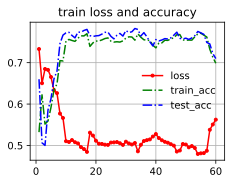

In [23]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
# losses, train_accuracy, test_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()